# Mean Sea Level Singapore

Mean Sea Level Prediction with Time Series Model 

Climate change is an urgent global issue that affects ecosystems, communities, and economies. This is evident from shifts in temperature, changes in precipitation patterns, and rising sea levels, all of which underscore the need for immediate understanding and action.

This project aims to explore the impact of global warming on Singapore's climate evidence from the change in rate of sea level rising trend. Several hypothesis testing conducted on monthly Mean Sea Level Tide Gauge Data collected by the Permanent Service for Mean Sea Level (PSMSL). And a time series forecast model built based on past observations, and used in predicting near future trend. 

## Objectives: 

1. To identify trends and seasonal patterns, 
2. To determine the significance of changes in sea level conditions with statistical hypothesis testing for trending 
3. To build a time series model (SARIMA) based on past observations and predict near future trend, with underlying seasonality preserved. 


## Table of Contents:
1. Retrieve Sea Level Tide Gauge Datasets directly from PSMSL website
2. Imputation for missing values in Time Series Data
3. Linear Regression plots for each Tide-gauge Station
4. Comparison of Mean Sea Level with .resample() between Monthly and Yearly Mean
5. Comparison of Mean Sea Level with varying Rolling Mean
6. Questions:
- What was the percentage increase in the mean value from the first year of measurement to the last year?
- In which year was the annual mean height the lowest since the start of measurements?
- In which years were the annual mean heights among the bottom 10 lowest since the start of measurements?
- Which 10 months had the highest annual mean heights since the start of measurements?
7. Comparion of Mean Sea Level with Simple Moving Averages (SMA) with Exponentially Weighted Moving Average (EWMA)
8. Using Statsmodels for conducting statistical tests, and EDA
9. Descriptive Statistics and Tests
- Tests for Stationarity
    - Augmented Dickey-Fuller Test
    - Kwiatkowski-Phillips-Schmidt-Shin
    - Philips-Perron Test
- Test for Trend
    - Mann-Kendall Test
10. Forecasting procedure
- ARIMA(p,d,q) forecasting model
11. Two main ways to choose these ARIMA(p,d,q) terms:
- Classical Method: 
    - AutoCorrelation Function (ACF)
    - Partial AutoCorrelation Function (PACF)
- Grid Search Method
12. SARIMA vs ARIMA models
13. Evaluate the Model
14. Conclusion
15. Reference



Lee Eik Shern

17-Aug-2023

In [23]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from statsmodels.graphics.tsaplots import month_plot,quarter_plot,plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

from helpers import scatter_plot_with_regression_line, sealevel_data_impute, station_id_input, sealevel_timeseries, adf_test, kpss_test, pp_test, mk_test, anderson_darling_test, shapiro_wilk_test, pearson_normality_test

"Tide Gauge Data”, Permanent Service for Mean Sea Level (PSMSL), 
Retrieved 31 Jul 2023 from http://www.psmsl.org/data/obtaining

## **`Tide Gauge Station ID`**


| Station ID | Station Names 
| --- | --- |
| 724 | SEMBAWANG
| 1183 | VICTORIA DOCK
| 1248 | SULTAN SHOAL
| 1275 | JURONG
| 1351 | RAFFLES LIGHT HOUSE
| 1534 | KEPPEL HARBOUR
| 1746 | TANJONG PAGAR
| 1894 | TUAS (WEST JURONG)
| 1895 | WEST COAST
| 1896 | WEST TUAS
| 2032 | BUKOM
| 2033 | TANJONG CHANGI
| 2034 | TANAH MERAH
| 2068 | UBIN

### Export a raw data file in .csv with selected Station ID [CLI]
``` python
$ python helpers.py

Please enter a Station ID: 1351

In [2]:
# Tide Gauge Station ID
station_id = {  
                724: 'SEMBAWANG', 
                1183: 'VICTORIA DOCK', 
                1248: 'SULTAN SHOAL', 
                1275: 'JURONG', 
                1351: 'RAFFLES LIGHT HOUSE', 
                1534: 'KEPPEL HARBOUR', 
                1746: 'TANJONG PAGAR', 
                1894: 'TUAS (WEST JURONG)', 
                1895: 'WEST COAST', 
                1896: 'WEST TUAS', 
                2032: 'BUKOM', 
                2033: 'TANJONG CHANGI', 
                2034: 'TANAH MERAH', 
                2068: 'UBIN'
            }

### Enter Station ID 

In [3]:
id = station_id_input(id)

The Station ID entered is 1351 with Station Name: RAFFLES LIGHT HOUSE


## Retrieve Sea Level Tide Gauge Datasets directly from PSMSL website

In [4]:
sealevel_timeseries_df_demo = sealevel_timeseries(id)
sealevel_timeseries_df_demo

height
date              
1979-06-01    6946
1979-07-01    6946
1979-08-01    6996
1979-09-01    7026
1979-10-01    7146
...            ...
2022-08-01    7132
2022-09-01    7158
2022-10-01    7266
2022-11-01    7273
2022-12-01    7358

[523 rows x 1 columns]

In [5]:
print(f"Earliest Date Value (Most earliest date):{sealevel_timeseries_df_demo.index.min()}") 
print(f"Latest Date Value (Most recent date):    {sealevel_timeseries_df_demo.index.max()}")
print(f"Latest Date Index Location:              {sealevel_timeseries_df_demo.index.argmax()}")
print(f"Highest Sea Level from Tide Gauge:       {sealevel_timeseries_df_demo['height'].max()}")
print(f"Highest Sea Level Date:                  {sealevel_timeseries_df_demo['height'].idxmax()}\n")

Earliest Date Value (Most earliest date):1979-06-01 00:00:00
Latest Date Value (Most recent date):    2022-12-01 00:00:00
Latest Date Index Location:              522
Highest Sea Level from Tide Gauge:       7358
Highest Sea Level Date:                  2022-12-01 00:00:00



## Imputation for missing values in Time Series Data

<Axes: xlabel='date'>

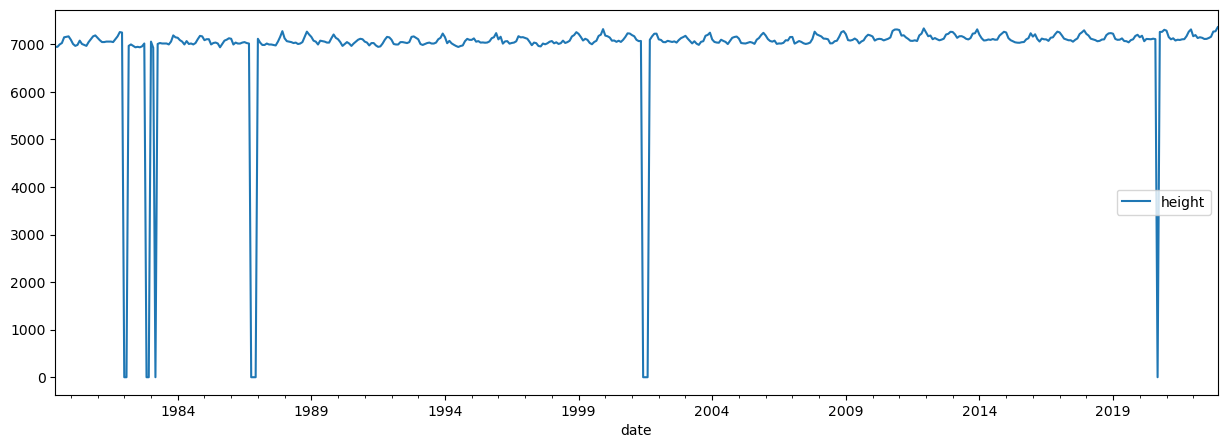

In [6]:
# Before Impute Missing Value
sealevel_timeseries_df_demo.plot(figsize=(15, 5))

In [7]:
# Replace '0' with 'NaN'
sealevel_timeseries_df_demo['height'].replace(0, np.nan, inplace=True)
# Check any 'NaN' values in column 'height'
print(f"NaN values after .replace(0, np.nan): {sealevel_timeseries_df_demo['height'].isna().sum()}") 

NaN values after .replace(0, np.nan): 12


In [8]:
print(len(sealevel_timeseries_df_demo))
sealevel_timeseries_df_demo.info()

523
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 1979-06-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  511 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


<Axes: xlabel='date'>

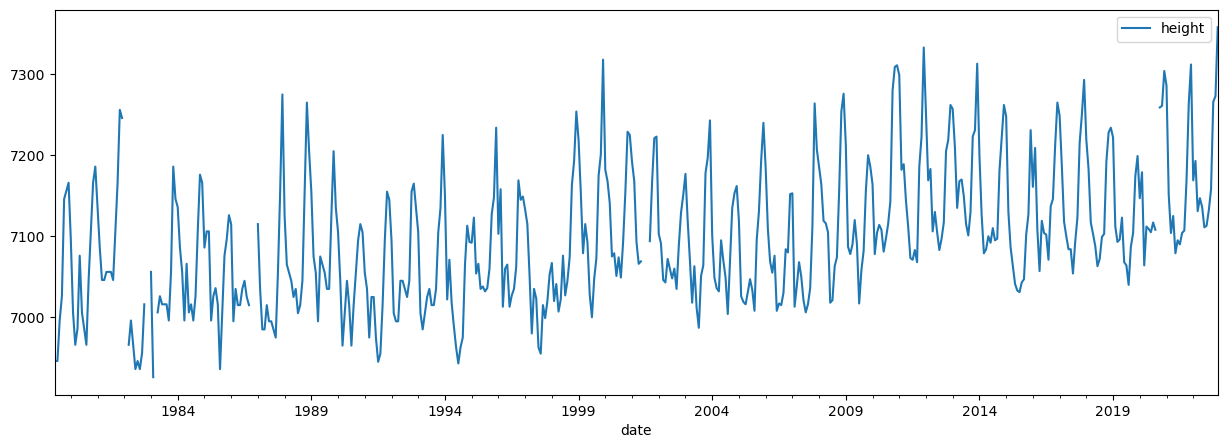

In [9]:
# Time Series Plot Before Impute "NaN" 
sealevel_timeseries_df_demo.plot(figsize=(15, 5))

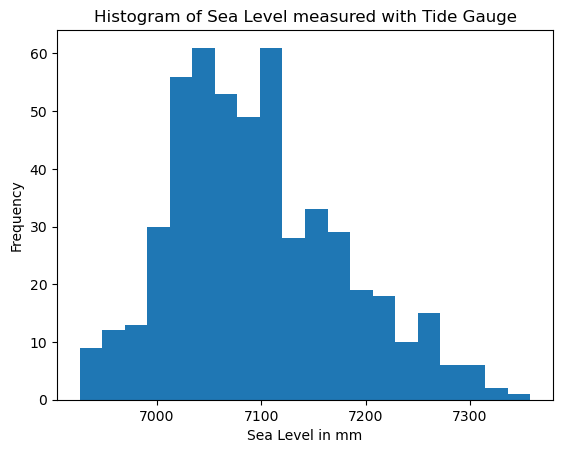

In [10]:
# Before Impute "NaN" 
plt.hist(sealevel_timeseries_df_demo['height'], bins=20)
plt.xlabel('Sea Level in mm')
plt.ylabel('Frequency')
plt.title('Histogram of Sea Level measured with Tide Gauge')
plt.show()

In [11]:
# DatetimeIndex with NaN values 
index_numbers = sealevel_timeseries_df_demo['height'].isna()
index_numbers_NA = index_numbers[index_numbers].index
print(index_numbers_NA)

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-11-01', '1982-12-01',
               '1983-03-01', '1986-10-01', '1986-11-01', '1986-12-01',
               '2001-06-01', '2001-07-01', '2001-08-01', '2020-09-01'],
              dtype='datetime64[ns]', name='date', freq=None)


### Imputation Method applied to `.fillna()`

In [12]:
# Imputing missing values using the rolling average
sealevel_timeseries_df_imputed = sealevel_timeseries_df_demo.assign(RollingMean=sealevel_timeseries_df_demo.height.fillna(sealevel_timeseries_df_demo.height.rolling(12,min_periods=1,).mean()))
# Imputing missing values using the rolling median
sealevel_timeseries_df_imputed = sealevel_timeseries_df_imputed.assign(RollingMedian=sealevel_timeseries_df_demo.height.fillna(sealevel_timeseries_df_demo.height.rolling(12,min_periods=1,).median()))# imputing using the median
# Imputing missing values using interpolation with linear & time methods
sealevel_timeseries_df_imputed = sealevel_timeseries_df_imputed.assign(InterpolateLinear=sealevel_timeseries_df_demo.height.interpolate(method='linear'))
sealevel_timeseries_df_imputed = sealevel_timeseries_df_imputed.assign(InterpolateTime=sealevel_timeseries_df_demo.height.interpolate(method='time'))

<Axes: xlabel='date'>

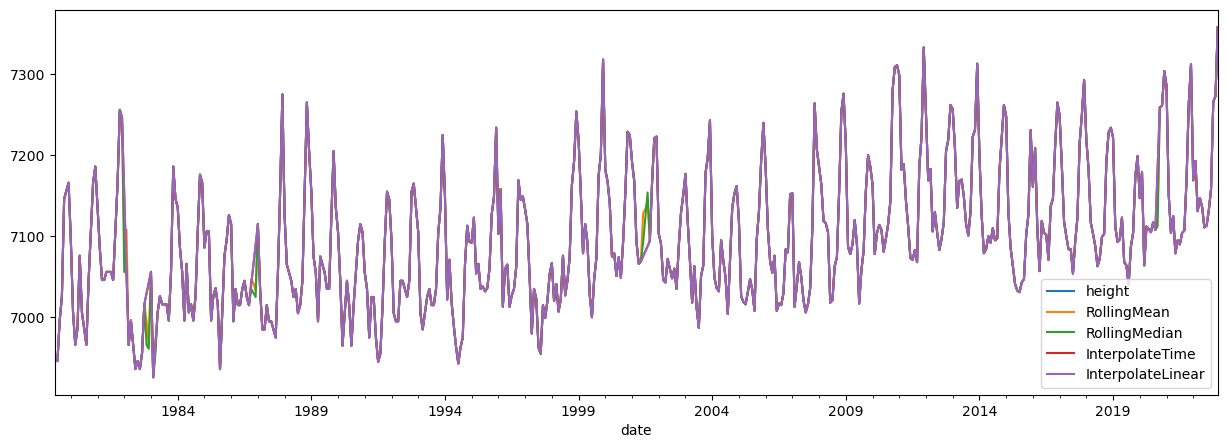

In [13]:
# After Impute "NaN" 
sealevel_timeseries_df_imputed[['height', 'RollingMean', 'RollingMedian', 'InterpolateTime', 'InterpolateLinear']].plot(figsize=(15, 5))

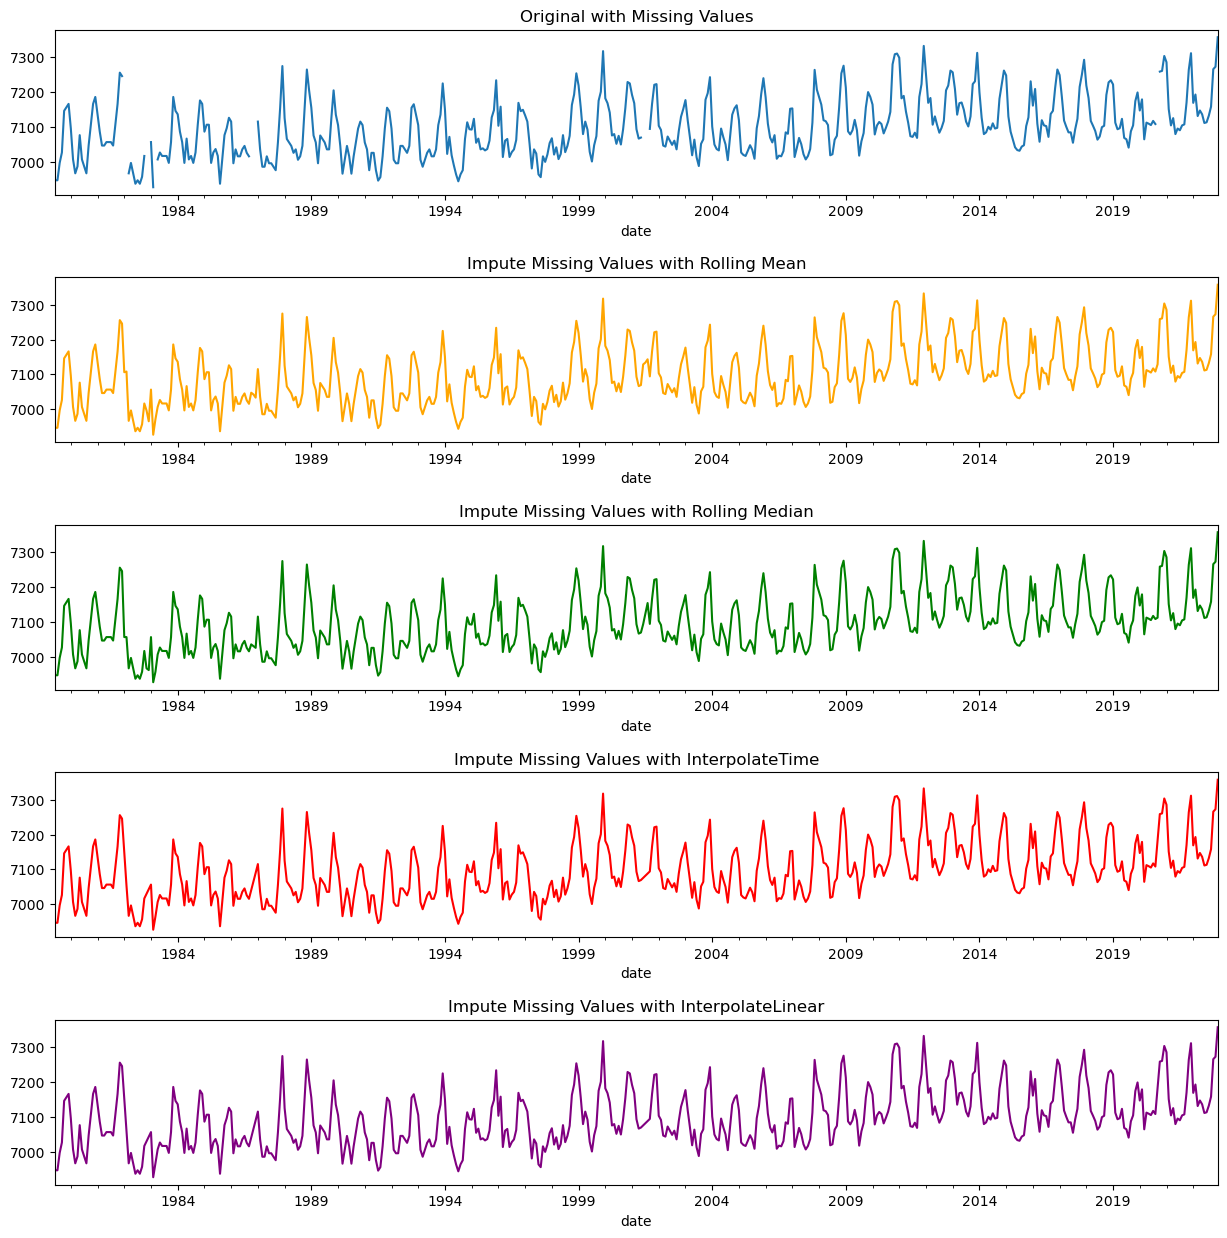

In [14]:
# Plot in seperate chart for comparison
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 15))

sealevel_timeseries_df_imputed['height'].plot(ax=axes[0])
sealevel_timeseries_df_imputed['RollingMean'].plot(ax=axes[1], color='orange')
sealevel_timeseries_df_imputed['RollingMedian'].plot(ax=axes[2], color='green')
sealevel_timeseries_df_imputed['InterpolateTime'].plot(ax=axes[3], color='red')
sealevel_timeseries_df_imputed['InterpolateLinear'].plot(ax=axes[4], color='purple')

axes[0].set_title('Original with Missing Values')
axes[1].set_title('Impute Missing Values with Rolling Mean')
axes[2].set_title('Impute Missing Values with Rolling Median')
axes[3].set_title('Impute Missing Values with InterpolateTime')
axes[4].set_title('Impute Missing Values with InterpolateLinear')

plt.subplots_adjust(hspace=0.5)
plt.show()

### Select Impute Method and replace 

In [15]:
# Selected 'RollingMean' impute method
sealevel_timeseries_df_imputed['height'] = sealevel_timeseries_df_imputed['RollingMean']#.astype(int)
sealevel_timeseries_df_demo_imputed = pd.DataFrame(sealevel_timeseries_df_imputed['height'])
sealevel_timeseries_df_demo_imputed

height
date              
1979-06-01  6946.0
1979-07-01  6946.0
1979-08-01  6996.0
1979-09-01  7026.0
1979-10-01  7146.0
...            ...
2022-08-01  7132.0
2022-09-01  7158.0
2022-10-01  7266.0
2022-11-01  7273.0
2022-12-01  7358.0

[523 rows x 1 columns]

<Axes: xlabel='date'>

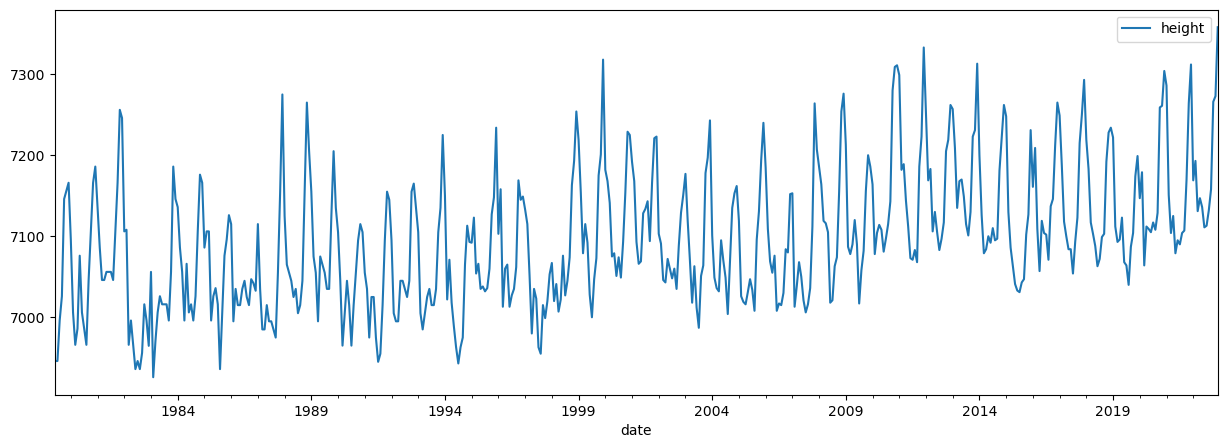

In [16]:
# After Impute Missing Value
sealevel_timeseries_df_demo_imputed.plot(figsize=(15, 5))

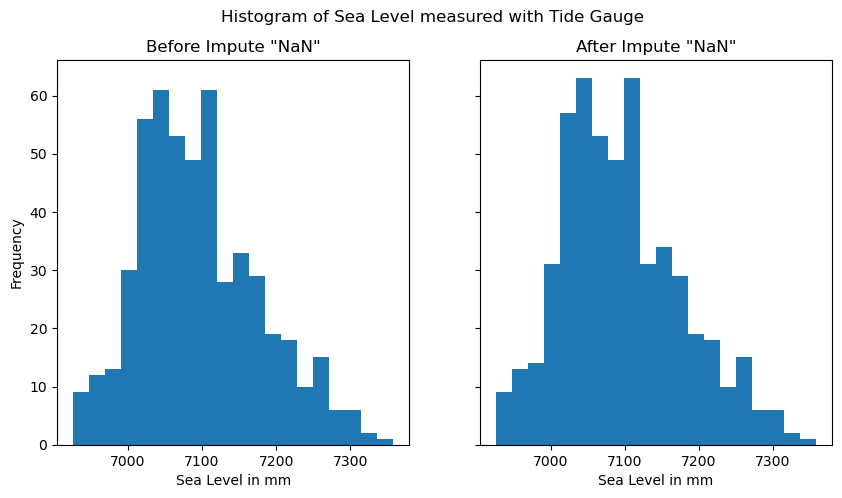

In [17]:
# Compare Histogram Before and After Impute "NaN" 
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].hist(sealevel_timeseries_df_demo['height'], bins=20)
axs[0].set_xlabel('Sea Level in mm')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Before Impute "NaN"')

axs[1].hist(sealevel_timeseries_df_demo_imputed['height'], bins=20)
axs[1].set_xlabel('Sea Level in mm')
axs[1].set_title('After Impute "NaN"')

fig.suptitle('Histogram of Sea Level measured with Tide Gauge')
plt.show()

In [21]:
# del id

### Integrate imputation process into sealevel data retrieval

In [22]:
# Check for any remaining NaN
for k in station_id:
    print(sealevel_data_impute(k).isna().sum())

Station ID (724): SEMBAWANG
height    0
dtype: int64
Station ID (1183): VICTORIA DOCK
height    0
dtype: int64
Station ID (1248): SULTAN SHOAL
height    0
dtype: int64
Station ID (1275): JURONG
height    0
dtype: int64
Station ID (1351): RAFFLES LIGHT HOUSE
height    0
dtype: int64
Station ID (1534): KEPPEL HARBOUR
height    0
dtype: int64
Station ID (1746): TANJONG PAGAR
height    0
dtype: int64
Station ID (1894): TUAS (WEST JURONG)
height    0
dtype: int64
Station ID (1895): WEST COAST
height    0
dtype: int64
Station ID (1896): WEST TUAS
height    0
dtype: int64
Station ID (2032): BUKOM
height    0
dtype: int64
Station ID (2033): TANJONG CHANGI
height    0
dtype: int64
Station ID (2034): TANAH MERAH
height    0
dtype: int64
Station ID (2068): UBIN
height    0
dtype: int64


## **`Linear Regression`** plots for each Tide-gauge Station

Although Linear Regression may not be suitable for modeling Mean Sea Level Rise due to `seasonality` with `cyclical` nature, it does provides a general visualization of underlying patterns such as trends (upward, downward, or stationary). Models like ARIMA or SARIMA might be more appropriate for this kind of data.

Station ID (724): SEMBAWANG


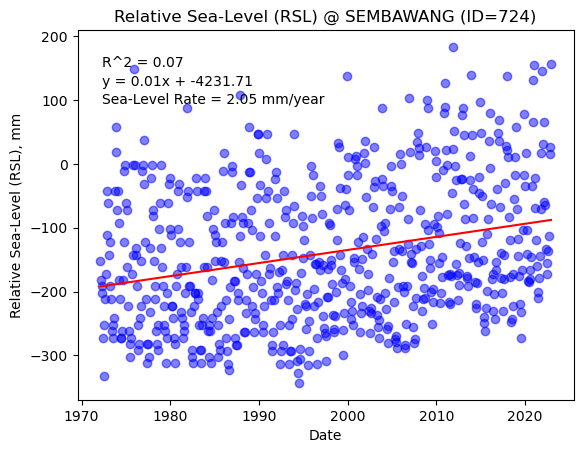

Station ID (1183): VICTORIA DOCK


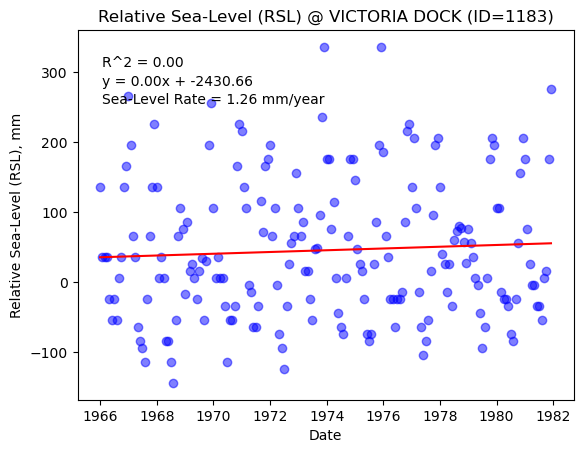

Station ID (1248): SULTAN SHOAL


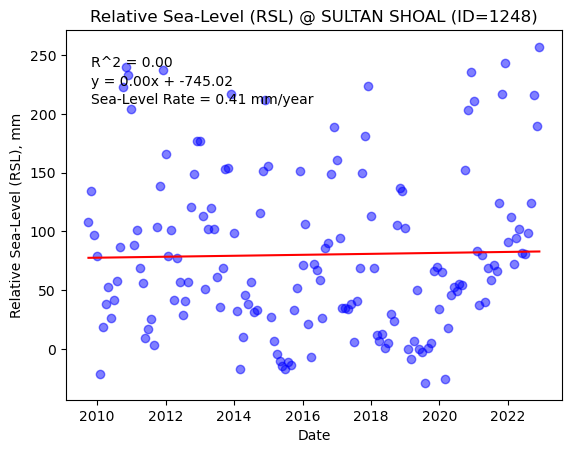

Station ID (1275): JURONG


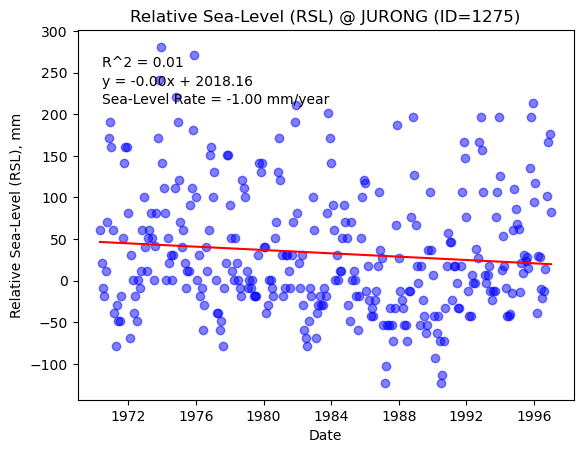

Station ID (1351): RAFFLES LIGHT HOUSE


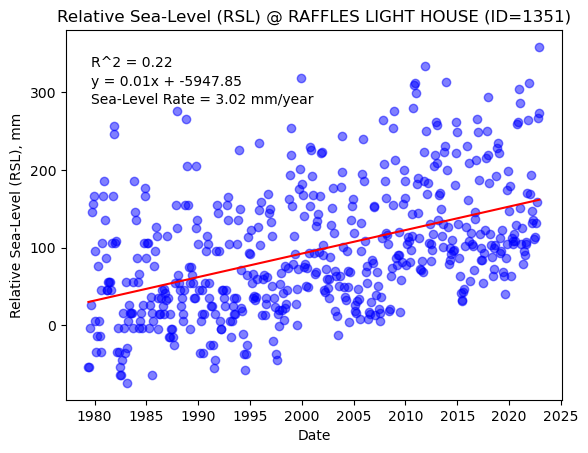

Station ID (1534): KEPPEL HARBOUR


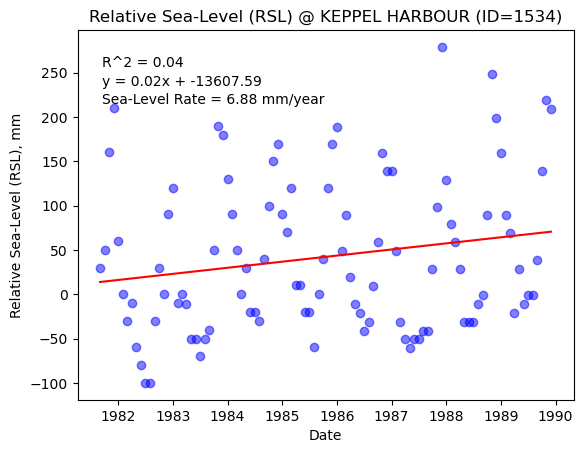

Station ID (1746): TANJONG PAGAR


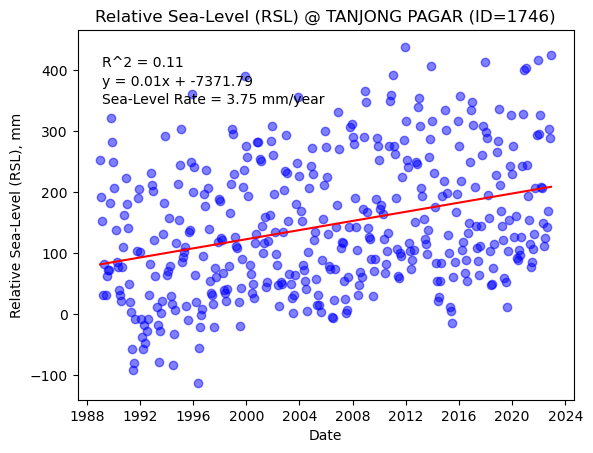

Station ID (1894): TUAS (WEST JURONG)


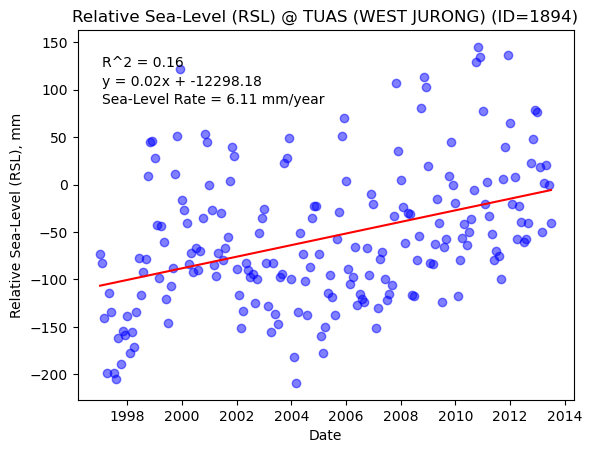

Station ID (1895): WEST COAST


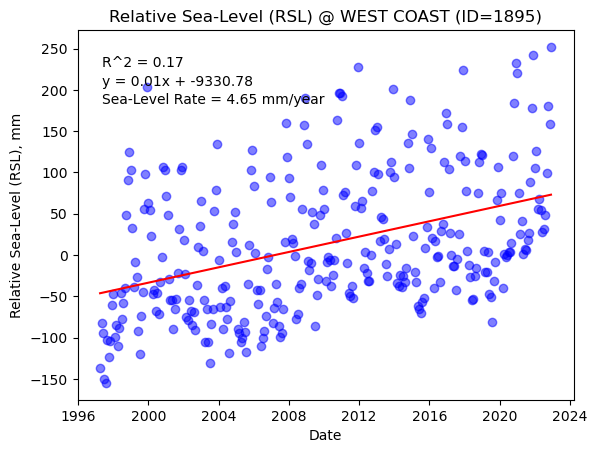

Station ID (1896): WEST TUAS


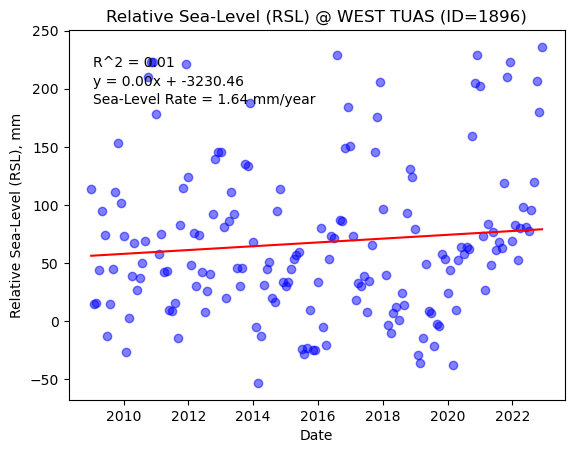

Station ID (2032): BUKOM


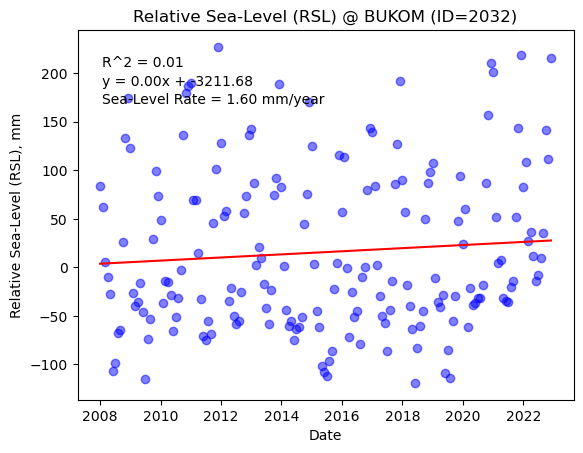

Station ID (2033): TANJONG CHANGI


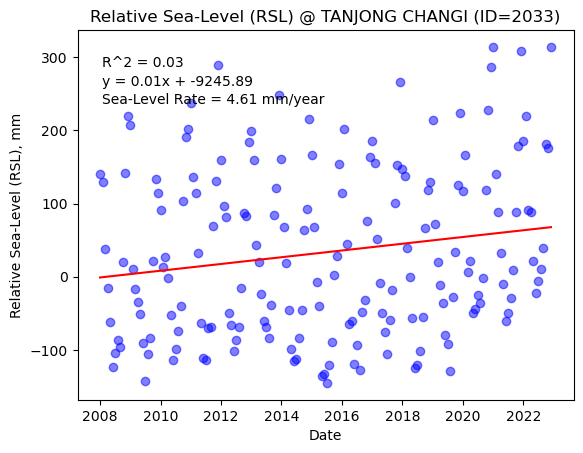

Station ID (2034): TANAH MERAH


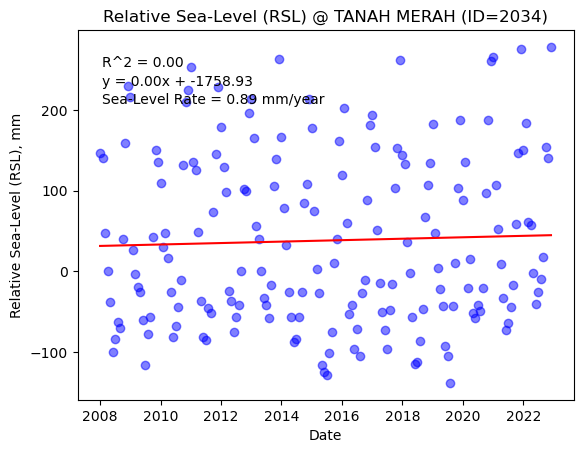

Station ID (2068): UBIN


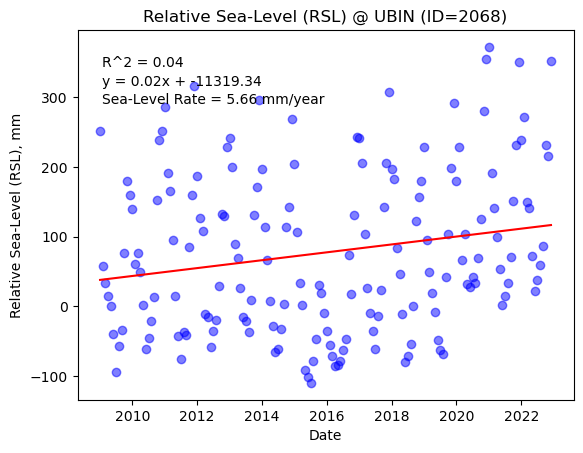

In [23]:
# Linear Regression plots for each Tide-gauge Station
for k in station_id:
    scatter_plot_with_regression_line(sealevel_data_impute(k),k)

Linear regression and moving average are two different methods for analyzing time series data. 

Linear regression is a statistical technique that models the relationship between a dependent variable and one or more independent variables. In the case of sea level rise time series data, linear regression can be used to model the relationship between time and sea level, and to make predictions about future sea levels based on past data.

On the other hand, a moving average is a technique for `smoothing time series data` by calculating the `average of a fixed number of data points at each point in time` by `resampling`. This can help to `reduce noise and reveal underlying trends` in the data.

Linear regression can be useful for making `predictions about future sea levels`, while a moving average can be useful for `visualizing trends in the data`. 

It’s also possible to `combine both methods`, by first applying a moving average to smooth out the data, and then using linear regression to model the relationship between time and the smoothed sea level data.

## Comparison of Mean Sea Level with .resample() between Monthly and Yearly Mean

Time Series Data Resampling with `.resample()` 

Resampling based on the time series index.
First need to pass in a **`rule`** parameter, that describes the frequency to apply the aggregation function (daily, monthly, yearly, etc.) later.

The **`rule`** parameter is passed in using an "offset alias" 

[TIME SERIES OFFSET ALIASES](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

The `aggregation function` is needed because, due to resampling, we need some sort of mathematical rule to join the rows (mean, sum, count, etc.)

In [24]:
# Enter Station ID 
# id = station_id_input(id)

In [25]:
sealevel_timeseries_df_final = sealevel_data_impute(id=id)
print(f"Datapoints: {len(sealevel_timeseries_df_final)}\n")
print(f"{sealevel_timeseries_df_final.index}\n")
sealevel_timeseries_df_final.info()

Station ID (1351): RAFFLES LIGHT HOUSE


Datapoints: 523

DatetimeIndex(['1979-06-01', '1979-07-01', '1979-08-01', '1979-09-01',
               '1979-10-01', '1979-11-01', '1979-12-01', '1980-01-01',
               '1980-02-01', '1980-03-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', length=523, freq=None)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 1979-06-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  523 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


### Use `.resample(rule=<time_period>)` to aggregate 

In [26]:
# 'A':year end frequency, similar as groupby, and average 'height' over yearly basis, and returned last day of that year
sealevel_timeseries_df_final.resample(rule='A').mean() 

height
date                  
1979-12-31   54.571429
1980-12-31   49.333333
1981-12-31  108.500000
1982-12-31   -8.937500
1983-12-31   34.703704
1984-12-31   69.333333
1985-12-31   51.000000
1986-12-31   34.739815
1987-12-31   47.500000
1988-12-31   86.666667
1989-12-31   84.166667
1990-12-31   44.166667
1991-12-31   33.333333
1992-12-31   61.666667
1993-12-31   57.500000
1994-12-31   30.416667
1995-12-31   87.083333
1996-12-31   83.250000
1997-12-31   28.500000
1998-12-31   82.416667
1999-12-31  125.083333
2000-12-31  126.666667
2001-12-31  141.448822
2002-12-31   77.166667
2003-12-31   98.250000
2004-12-31   79.500000
2005-12-31   80.083333
2006-12-31   73.333333
2007-12-31   82.083333
2008-12-31  129.166667
2009-12-31  114.750000
2010-12-31  158.666667
2011-12-31  163.583333
2012-12-31  160.500000
2013-12-31  183.416667
2014-12-31  137.333333
2015-12-31   98.583333
2016-12-31  141.000000
2017-12-31  154.166667
2018-12-31  141.750000
2019-12-31  115.166667
2020-12-31  157.825758
2021-12-31  157.250000
2022-12-31  182.250000

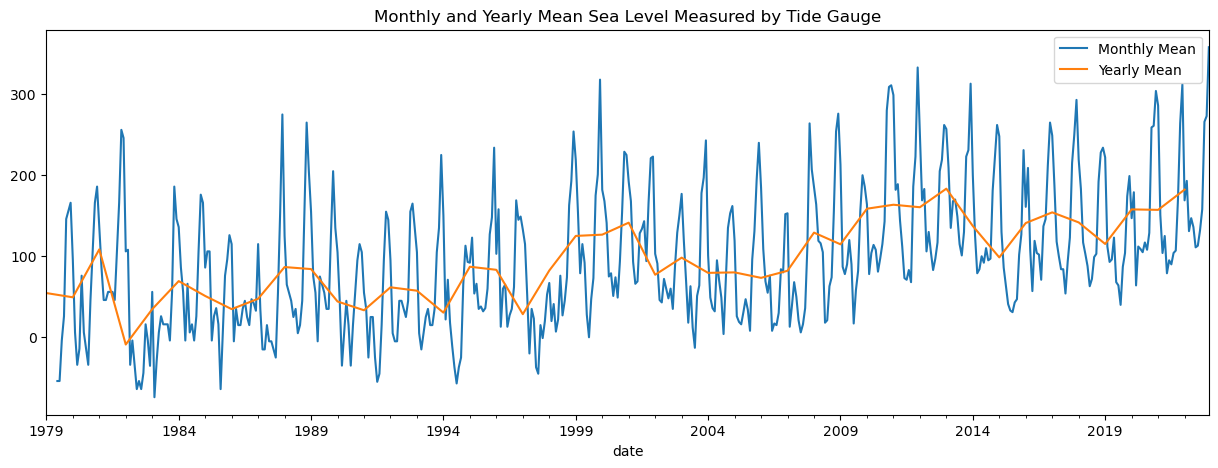

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sealevel_timeseries_df_final['height'].plot(ax=ax, label='Monthly Mean')
sealevel_timeseries_df_final.resample(rule='A').mean()['height'].plot(ax=ax, label='Yearly Mean')

ax.set_title('Monthly and Yearly Mean Sea Level Measured by Tide Gauge')
ax.legend()
plt.show()

### Column Value Shifting with `.shift()`

In [28]:
print(sealevel_timeseries_df_final.head(),"\n")
print(sealevel_timeseries_df_final.tail(),"\n")
sealevel_timeseries_df_final.info()

            height
date              
1979-06-01   -54.0
1979-07-01   -54.0
1979-08-01    -4.0
1979-09-01    26.0
1979-10-01   146.0 

            height
date              
2022-08-01   132.0
2022-09-01   158.0
2022-10-01   266.0
2022-11-01   273.0
2022-12-01   358.0 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 1979-06-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  523 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


### **`.shift(+ve)`** forward

In [29]:
print(sealevel_timeseries_df_final.shift(1).head(),"\n")
print(sealevel_timeseries_df_final.shift(1).tail()) # Lose last 'height' that no longer has an index

            height
date              
1979-06-01     NaN
1979-07-01   -54.0
1979-08-01   -54.0
1979-09-01    -4.0
1979-10-01    26.0 

            height
date              
2022-08-01   113.0
2022-09-01   132.0
2022-10-01   158.0
2022-11-01   266.0
2022-12-01   273.0


### **`.shift(-ve)`** backwards

In [30]:
print(sealevel_timeseries_df_final.shift(-1).head(),"\n")
print(sealevel_timeseries_df_final.shift(-1).tail())

            height
date              
1979-06-01   -54.0
1979-07-01    -4.0
1979-08-01    26.0
1979-09-01   146.0
1979-10-01   156.0 

            height
date              
2022-08-01   158.0
2022-09-01   266.0
2022-10-01   273.0
2022-11-01   358.0
2022-12-01     NaN


### Time Index Shifting with `.shift(periods, freq)` based on `Time Series Frequency Code`
[DataFrame.shift(periods=1, freq=None, axis=0, fill_value=_NoDefault.no_default)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)

Common codes are:
- `'M'` for `month-end`
- `'A'` for `year-end`



reference ([offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases )): 


In [31]:
print(sealevel_timeseries_df_final.head(),"\n")
print(sealevel_timeseries_df_final.tail())

            height
date              
1979-06-01   -54.0
1979-07-01   -54.0
1979-08-01    -4.0
1979-09-01    26.0
1979-10-01   146.0 

            height
date              
2022-08-01   132.0
2022-09-01   158.0
2022-10-01   266.0
2022-11-01   273.0
2022-12-01   358.0


In [32]:
print(sealevel_timeseries_df_final.shift(periods=1, freq='M').head(),"\n")
print(sealevel_timeseries_df_final.shift(periods=1, freq='M').tail())

            height
date              
1979-06-30   -54.0
1979-07-31   -54.0
1979-08-31    -4.0
1979-09-30    26.0
1979-10-31   146.0 

            height
date              
2022-08-31   132.0
2022-09-30   158.0
2022-10-31   266.0
2022-11-30   273.0
2022-12-31   358.0


### Rolling with `.rolling(window)`

`.rolling(window=<#rows> to roll up).<aggregation>`

In [33]:
print(sealevel_timeseries_df_final.head(),"\n")
print(sealevel_timeseries_df_final.tail())

            height
date              
1979-06-01   -54.0
1979-07-01   -54.0
1979-08-01    -4.0
1979-09-01    26.0
1979-10-01   146.0 

            height
date              
2022-08-01   132.0
2022-09-01   158.0
2022-10-01   266.0
2022-11-01   273.0
2022-12-01   358.0


In [34]:
sealevel_timeseries_df_final.rolling(window=2).mean()['height']

date
1979-06-01      NaN
1979-07-01    -54.0
1979-08-01    -29.0
1979-09-01     11.0
1979-10-01     86.0
              ...  
2022-08-01    122.5
2022-09-01    145.0
2022-10-01    212.0
2022-11-01    269.5
2022-12-01    315.5
Name: height, Length: 523, dtype: float64

## Comparison of Mean Sea Level with varying Rolling Mean

Comparison of Mean Sea Level with varying rolling window by `.rolling(window).mean()`

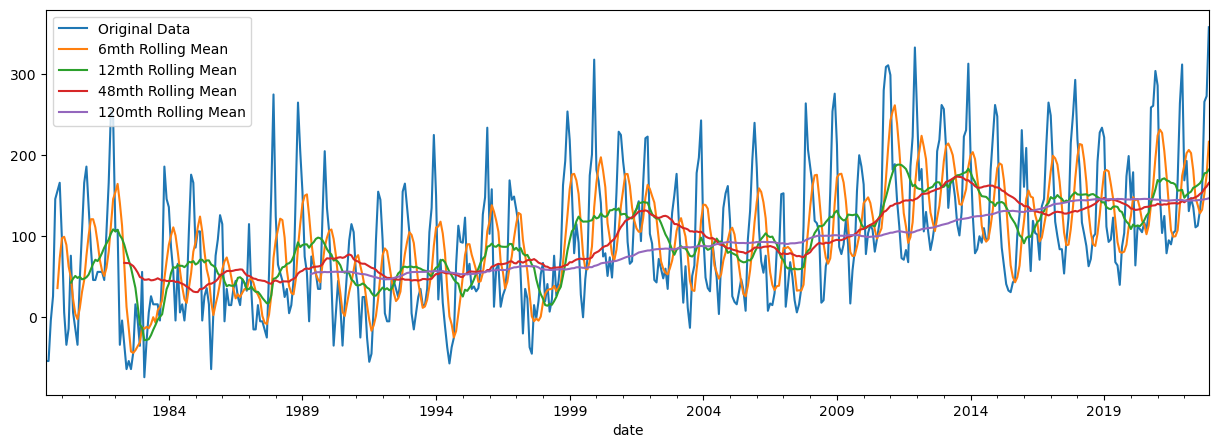

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))

sealevel_timeseries_df_final['height'].plot(ax=ax, label='Original Data')
sealevel_timeseries_df_final.rolling(window=6).mean()['height'].plot(ax=ax, label='6mth Rolling Mean')
sealevel_timeseries_df_final.rolling(window=12).mean()['height'].plot(ax=ax, label='12mth Rolling Mean')
sealevel_timeseries_df_final.rolling(window=36).mean()['height'].plot(ax=ax, label='48mth Rolling Mean')
sealevel_timeseries_df_final.rolling(window=120).mean()['height'].plot(ax=ax, label='120mth Rolling Mean')

ax.legend()
ax.autoscale(axis='x', tight=True)
plt.show()

In [36]:
sealevel_timeseries_df_final['height: 12mth Rolling Mean'] = sealevel_timeseries_df_final['height'].rolling(window=12).mean()
sealevel_timeseries_df_final.head(20)

height  height: 12mth Rolling Mean
date                                          
1979-06-01   -54.0                         NaN
1979-07-01   -54.0                         NaN
1979-08-01    -4.0                         NaN
1979-09-01    26.0                         NaN
1979-10-01   146.0                         NaN
1979-11-01   156.0                         NaN
1979-12-01   166.0                         NaN
1980-01-01    96.0                         NaN
1980-02-01     6.0                         NaN
1980-03-01   -34.0                         NaN
1980-04-01   -14.0                         NaN
1980-05-01    76.0                   42.666667
1980-06-01     6.0                   47.666667
1980-07-01   -14.0                   51.000000
1980-08-01   -34.0                   48.500000
1980-09-01    46.0                   50.166667
1980-10-01   106.0                   46.833333
1980-11-01   166.0                   47.666667
1980-12-01   186.0                   49.333333
1981-01-01   136.0                   52.666667

## Questions:
### **What was the percentage increase in the mean value from the first year of measurement to the last year?**

In [37]:
# Mean Sea Level height in 1st year 
start = sealevel_timeseries_df_final.iloc[0:12].mean()
print(start['height'])
# Mean Sea Level height in last 1 year 
end = sealevel_timeseries_df_final.iloc[(len(sealevel_timeseries_df_final) - 12):(len(sealevel_timeseries_df_final))].mean()
print(end['height'])

42.666666666666664
182.25


In [38]:
# Average Sea Level height (mm) Increase/Decrease per year average over period since started to last year
delta = (end - start)
print(f"Mean height increase(+)/decrease(-) since started measurement: {round(delta['height'],2)}mm")
pct_chg = (delta / start)*100
print(f"Percent increase(+)/decrease(-) since started measurement: {round(pct_chg['height'],2)}%")
avg_delta_yr = delta / (len(sealevel_timeseries_df_final)/12)
print(f"Average increase(+)/decrease(-) per year since started measurement: {round(avg_delta_yr['height'], 2)}mm/year")

Mean height increase(+)/decrease(-) since started measurement: 139.58mm
Percent increase(+)/decrease(-) since started measurement: 327.15%
Average increase(+)/decrease(-) per year since started measurement: 3.2mm/year


In [39]:
sealevel_timeseries_df_final

height  height: 12mth Rolling Mean
date                                          
1979-06-01   -54.0                         NaN
1979-07-01   -54.0                         NaN
1979-08-01    -4.0                         NaN
1979-09-01    26.0                         NaN
1979-10-01   146.0                         NaN
...            ...                         ...
2022-08-01   132.0                  165.416667
2022-09-01   158.0                  169.666667
2022-10-01   266.0                  177.666667
2022-11-01   273.0                  178.416667
2022-12-01   358.0                  182.250000

[523 rows x 2 columns]

### Another way to answer the question, by using `.resample(rule='A')`

In [40]:
sealevel_timeseries_df_final_resample_annum = pd.DataFrame(sealevel_timeseries_df_final['height'])
sealevel_timeseries_df_final_resample_annum = sealevel_timeseries_df_final_resample_annum.resample(rule='A').mean()
sealevel_timeseries_df_final_resample_annum

height
date                  
1979-12-31   54.571429
1980-12-31   49.333333
1981-12-31  108.500000
1982-12-31   -8.937500
1983-12-31   34.703704
1984-12-31   69.333333
1985-12-31   51.000000
1986-12-31   34.739815
1987-12-31   47.500000
1988-12-31   86.666667
1989-12-31   84.166667
1990-12-31   44.166667
1991-12-31   33.333333
1992-12-31   61.666667
1993-12-31   57.500000
1994-12-31   30.416667
1995-12-31   87.083333
1996-12-31   83.250000
1997-12-31   28.500000
1998-12-31   82.416667
1999-12-31  125.083333
2000-12-31  126.666667
2001-12-31  141.448822
2002-12-31   77.166667
2003-12-31   98.250000
2004-12-31   79.500000
2005-12-31   80.083333
2006-12-31   73.333333
2007-12-31   82.083333
2008-12-31  129.166667
2009-12-31  114.750000
2010-12-31  158.666667
2011-12-31  163.583333
2012-12-31  160.500000
2013-12-31  183.416667
2014-12-31  137.333333
2015-12-31   98.583333
2016-12-31  141.000000
2017-12-31  154.166667
2018-12-31  141.750000
2019-12-31  115.166667
2020-12-31  157.825758
2021-12-31  157.250000
2022-12-31  182.250000

In [41]:
sealevel_timeseries_df_final_resample_annum.index.argmin()

0

In [42]:
sealevel_timeseries_df_final_resample_annum['height'][sealevel_timeseries_df_final_resample_annum.index.argmin()]

54.57142857142857

In [43]:
sealevel_timeseries_df_final_resample_annum.index.argmax()

43

In [44]:
sealevel_timeseries_df_final_resample_annum['height'][sealevel_timeseries_df_final_resample_annum.index.argmax()]

182.25

### **In which year was the annual mean height the lowest since the start of measurements?**

In [45]:
print(f"Lowest height is {sealevel_timeseries_df_final['height'].min()} since started measurement in {sealevel_timeseries_df_final['height'].loc[:].idxmin()}")

Lowest height is -74.0 since started measurement in 1983-02-01 00:00:00


In [46]:
print(f"Lowest annual mean height is {sealevel_timeseries_df_final_resample_annum['height'].min()} since started measurement in {sealevel_timeseries_df_final_resample_annum['height'].loc[:].idxmin()}")

Lowest annual mean height is -8.9375 since started measurement in 1982-12-31 00:00:00


### **In which years were the annual mean heights among the bottom 10 lowest since the start of measurements?**

In [47]:
sealevel_timeseries_df_final_resample_annum.sort_values(by='height',ascending=True).head(10)

height
date                 
1982-12-31  -8.937500
1997-12-31  28.500000
1994-12-31  30.416667
1991-12-31  33.333333
1983-12-31  34.703704
1986-12-31  34.739815
1990-12-31  44.166667
1987-12-31  47.500000
1980-12-31  49.333333
1985-12-31  51.000000

### **Which 10 months had the highest annual mean heights since the start of measurements?**

In [48]:
sealevel_timeseries_df_final_resample_annum.sort_values(by='height',ascending=False).head(10)

height
date                  
2013-12-31  183.416667
2022-12-31  182.250000
2011-12-31  163.583333
2012-12-31  160.500000
2010-12-31  158.666667
2020-12-31  157.825758
2021-12-31  157.250000
2017-12-31  154.166667
2018-12-31  141.750000
2001-12-31  141.448822

**Bar plot showing the annual mean height in mm of sea level per year**

In [49]:
sealevel_timeseries_df_final_resample_annum

height
date                  
1979-12-31   54.571429
1980-12-31   49.333333
1981-12-31  108.500000
1982-12-31   -8.937500
1983-12-31   34.703704
1984-12-31   69.333333
1985-12-31   51.000000
1986-12-31   34.739815
1987-12-31   47.500000
1988-12-31   86.666667
1989-12-31   84.166667
1990-12-31   44.166667
1991-12-31   33.333333
1992-12-31   61.666667
1993-12-31   57.500000
1994-12-31   30.416667
1995-12-31   87.083333
1996-12-31   83.250000
1997-12-31   28.500000
1998-12-31   82.416667
1999-12-31  125.083333
2000-12-31  126.666667
2001-12-31  141.448822
2002-12-31   77.166667
2003-12-31   98.250000
2004-12-31   79.500000
2005-12-31   80.083333
2006-12-31   73.333333
2007-12-31   82.083333
2008-12-31  129.166667
2009-12-31  114.750000
2010-12-31  158.666667
2011-12-31  163.583333
2012-12-31  160.500000
2013-12-31  183.416667
2014-12-31  137.333333
2015-12-31   98.583333
2016-12-31  141.000000
2017-12-31  154.166667
2018-12-31  141.750000
2019-12-31  115.166667
2020-12-31  157.825758
2021-12-31  157.250000
2022-12-31  182.250000

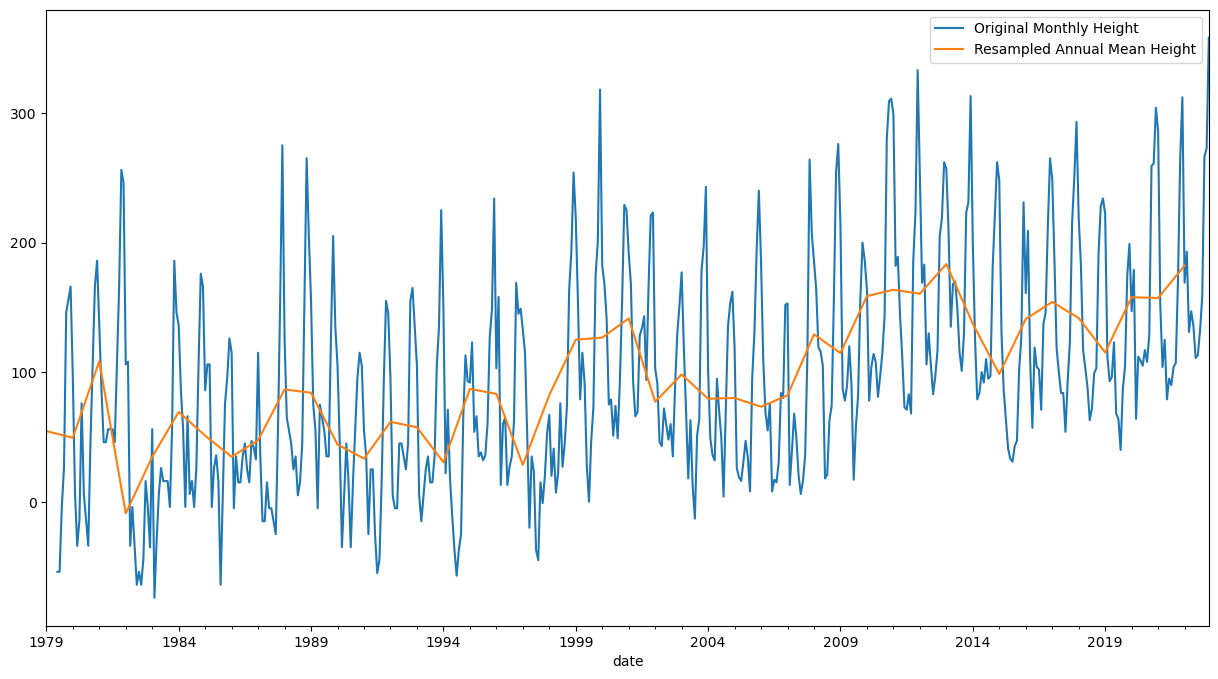

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))

sealevel_timeseries_df_final['height'].plot(ax=ax, label='Original Monthly Height')
sealevel_timeseries_df_final_resample_annum['height'].plot(ax=ax, label='Resampled Annual Mean Height')

ax.legend()
plt.show()

## Comparion of Simple Moving Averages, **`SMA`** `.rolling(window)` with Exponentially Weighted Moving Average, **`EWMA`** `.ewm(span)`

### Simple Moving Average, **`SMA`**

In [51]:
sealevel_timeseries_df_MA = pd.DataFrame(sealevel_timeseries_df_final['height'])
sealevel_timeseries_df_MA['SMA_6mo'] = sealevel_timeseries_df_MA['height'].rolling(window=6).mean()
sealevel_timeseries_df_MA['SMA_12mo'] = sealevel_timeseries_df_MA['height'].rolling(window=12).mean()

In [52]:
sealevel_timeseries_df_MA.head(20)

height     SMA_6mo   SMA_12mo
date                                     
1979-06-01   -54.0         NaN        NaN
1979-07-01   -54.0         NaN        NaN
1979-08-01    -4.0         NaN        NaN
1979-09-01    26.0         NaN        NaN
1979-10-01   146.0         NaN        NaN
1979-11-01   156.0   36.000000        NaN
1979-12-01   166.0   72.666667        NaN
1980-01-01    96.0   97.666667        NaN
1980-02-01     6.0   99.333333        NaN
1980-03-01   -34.0   89.333333        NaN
1980-04-01   -14.0   62.666667        NaN
1980-05-01    76.0   49.333333  42.666667
1980-06-01     6.0   22.666667  47.666667
1980-07-01   -14.0    4.333333  51.000000
1980-08-01   -34.0   -2.333333  48.500000
1980-09-01    46.0   11.000000  50.166667
1980-10-01   106.0   31.000000  46.833333
1980-11-01   166.0   46.000000  47.666667
1980-12-01   186.0   76.000000  49.333333
1981-01-01   136.0  101.000000  52.666667

<Axes: xlabel='date'>

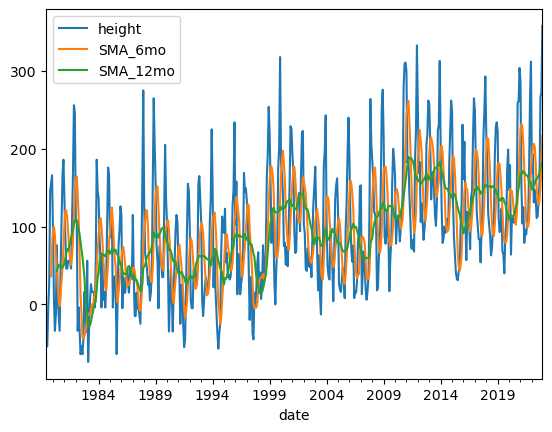

In [53]:
sealevel_timeseries_df_MA.plot()

### Exponentially Weighted Moving Average, **`EWMA`**

In [54]:
sealevel_timeseries_df_MA['EWMA_12'] = sealevel_timeseries_df_MA['height'].ewm(span=12,adjust=False).mean()

<Axes: xlabel='date'>

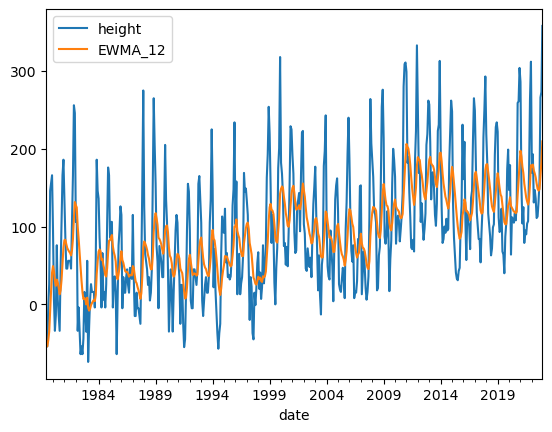

In [55]:
sealevel_timeseries_df_MA[['height','EWMA_12']].plot()

In [56]:
sealevel_timeseries_df_MA

height     SMA_6mo    SMA_12mo     EWMA_12
date                                                  
1979-06-01   -54.0         NaN         NaN  -54.000000
1979-07-01   -54.0         NaN         NaN  -54.000000
1979-08-01    -4.0         NaN         NaN  -46.307692
1979-09-01    26.0         NaN         NaN  -35.183432
1979-10-01   146.0         NaN         NaN   -7.309058
...            ...         ...         ...         ...
2022-08-01   132.0  128.333333  165.416667  146.221002
2022-09-01   158.0  132.833333  169.666667  148.033155
2022-10-01   266.0  152.666667  177.666667  166.181901
2022-11-01   273.0  175.500000  178.416667  182.615454
2022-12-01   358.0  216.666667  182.250000  209.597692

[523 rows x 4 columns]

### Comparing **`SMA`** to **`EWMA`**

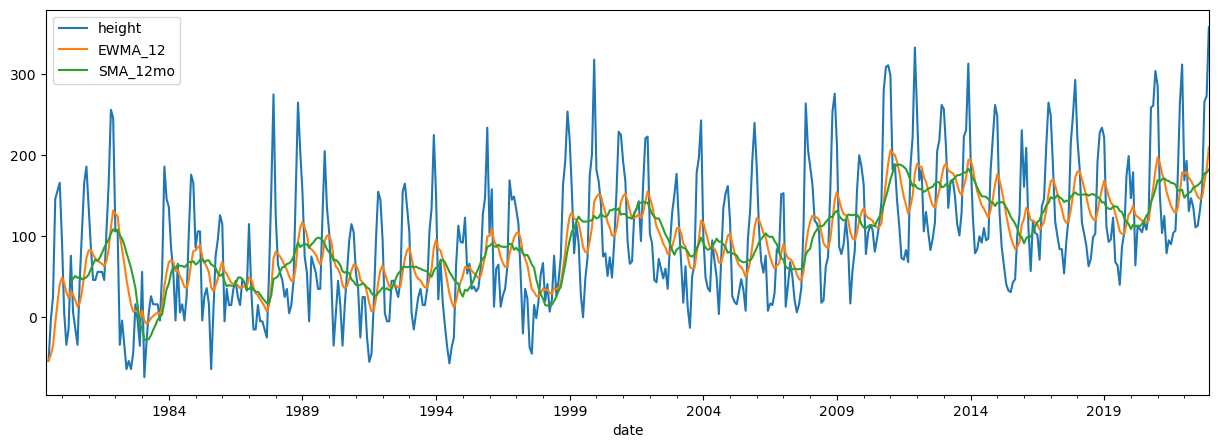

In [57]:
sealevel_timeseries_df_MA[['height','EWMA_12','SMA_12mo']].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

`Moving Average (MA)` methods are easy to understand and implement, and can be effective for forecasting time series data with no trend or seasonal patterns. 

However, they may not perform as well for data with more complex patterns, such as `trends` or `seasonality`, which is likely the sea level with seasonal high/low tides

In such cases, more advanced forecasting methods, such as `Holt-Winters` or `ARIMA`, may be more appropriate.

Each model addresses a different type of time series. For this reason, in order to select an appropriate model we need to know something about the data by runing some **`Descriptive Statistics` and `Tests`**, prior to conduct any advanced forecasting method, in order to make sure certain assumptions are met. 

## Using **`Statsmodels`** for conducting statistical tests, and EDA

### Plot the dataset

[Text(0, 0.5, 'Sea Level measured by Tide Gauge, mm')]

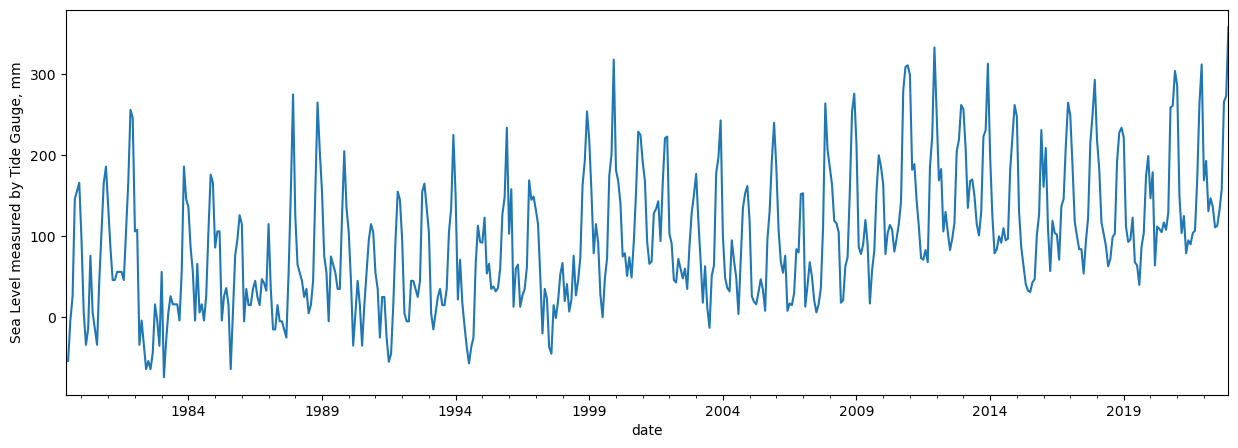

In [58]:
ax = sealevel_timeseries_df_final['height'].plot(figsize=(15,5))
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='Sea Level measured by Tide Gauge, mm')

### Using Statsmodels [statsmodels.tsa.filters.hp_filter.hpfilter](https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html) to visualize the trend of time series data

When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [59]:
sealevel_timeseries_df_trend = pd.DataFrame(sealevel_timeseries_df_final['height'])
(sealevel_cycle, sealevel_trend) = hpfilter(sealevel_timeseries_df_trend['height'], lamb=129600)
print(f"sealevel_cycle: {sealevel_cycle}\n")
print(f"sealevel_trend: {sealevel_trend}")

sealevel_cycle: date
1979-06-01   -106.216512
1979-07-01   -106.303267
1979-08-01    -56.389201
1979-09-01    -26.472676
1979-10-01     93.448383
                 ...    
2022-08-01    -49.436027
2022-09-01    -24.898371
2022-10-01     81.633359
2022-11-01     87.161782
2022-12-01    170.688888
Name: height_cycle, Length: 523, dtype: float64

sealevel_trend: date
1979-06-01     52.216512
1979-07-01     52.303267
1979-08-01     52.389201
1979-09-01     52.472676
1979-10-01     52.551617
                 ...    
2022-08-01    181.436027
2022-09-01    182.898371
2022-10-01    184.366641
2022-11-01    185.838218
2022-12-01    187.311112
Name: height_trend, Length: 523, dtype: float64


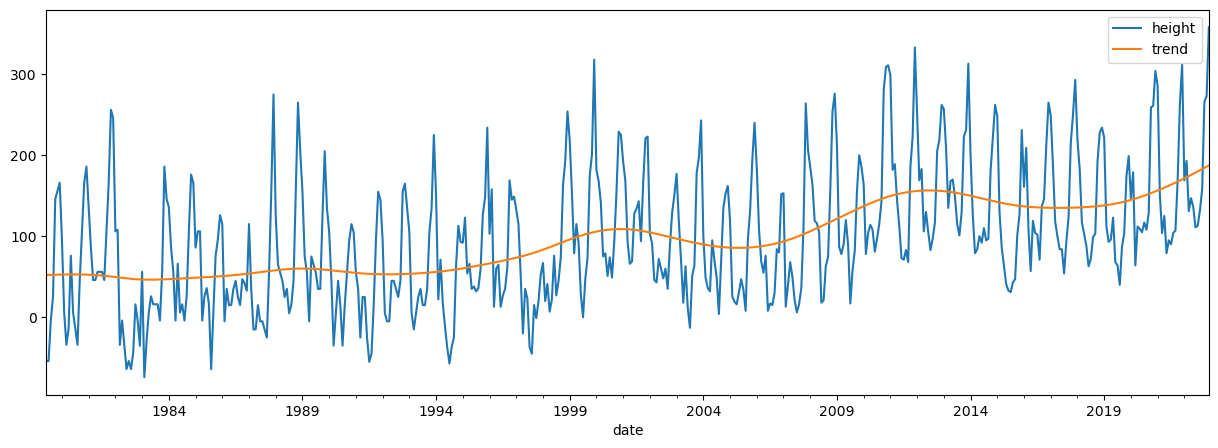

In [60]:
sealevel_timeseries_df_trend['trend'] = sealevel_trend
sealevel_timeseries_df_trend[['height','trend']].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

### Use `statsmodels.tsa.seasonal` with `seasonal_decompose` to decompose `Error`, `Trend`, `Seasonality` from time series data

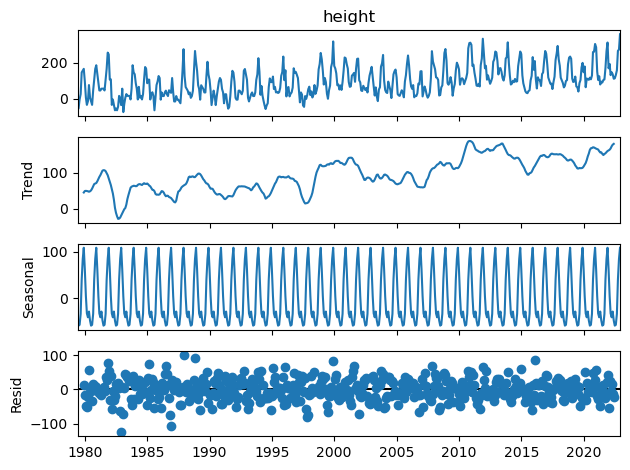

In [61]:
timeseries_decompose = seasonal_decompose(sealevel_timeseries_df_final['height'], model='additive')  
timeseries_decompose.plot();

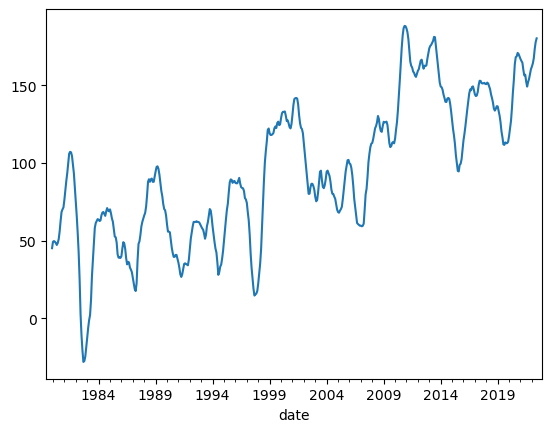

In [62]:
timeseries_decompose.trend.plot();

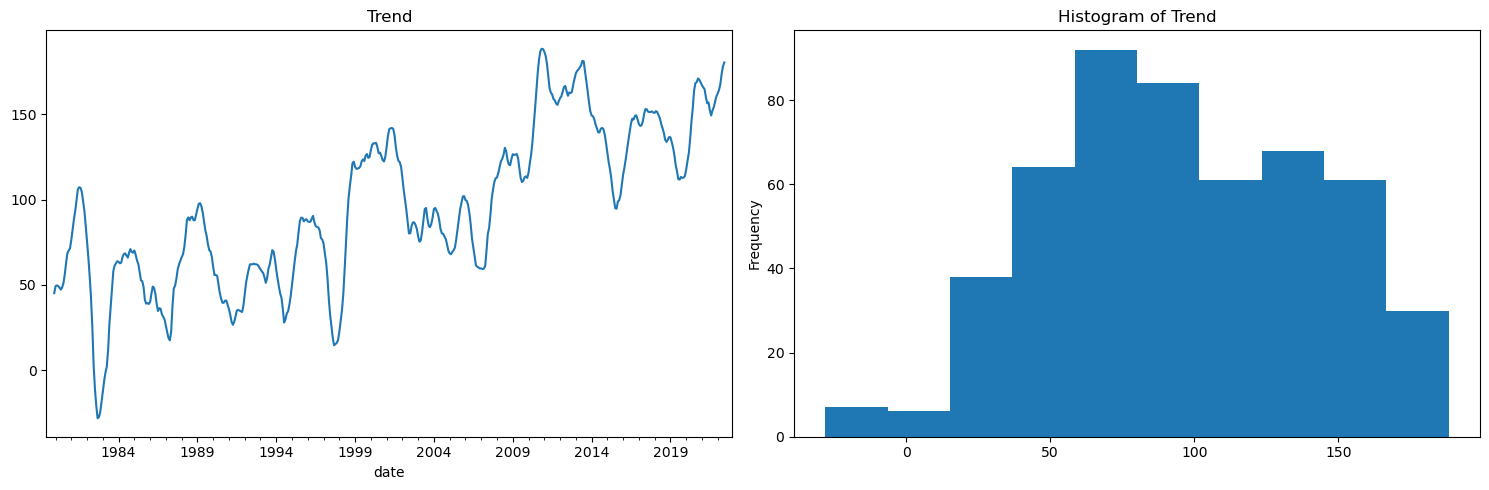

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
timeseries_decompose.trend.plot(ax=axs[0])
axs[0].set_title('Trend')
timeseries_decompose.trend.plot.hist(ax=axs[1])
axs[1].set_title('Histogram of Trend')
plt.tight_layout()

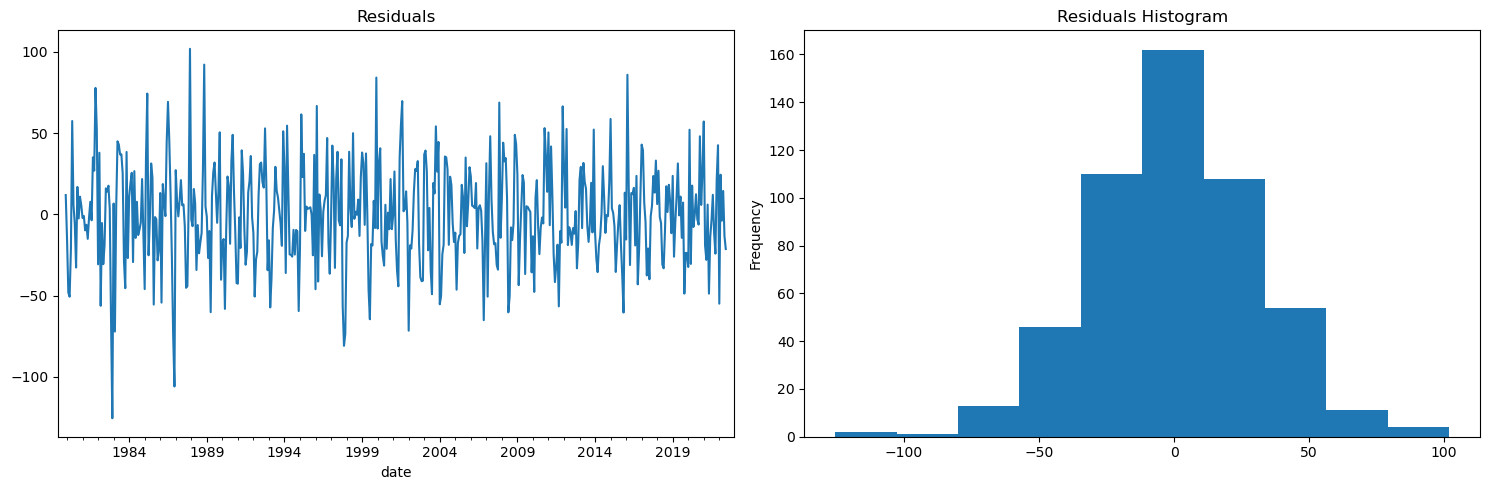

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
timeseries_decompose.resid.plot(ax=axs[0])
axs[0].set_title('Residuals')
timeseries_decompose.resid.plot.hist(ax=axs[1])
axs[1].set_title('Residuals Histogram')
plt.tight_layout()

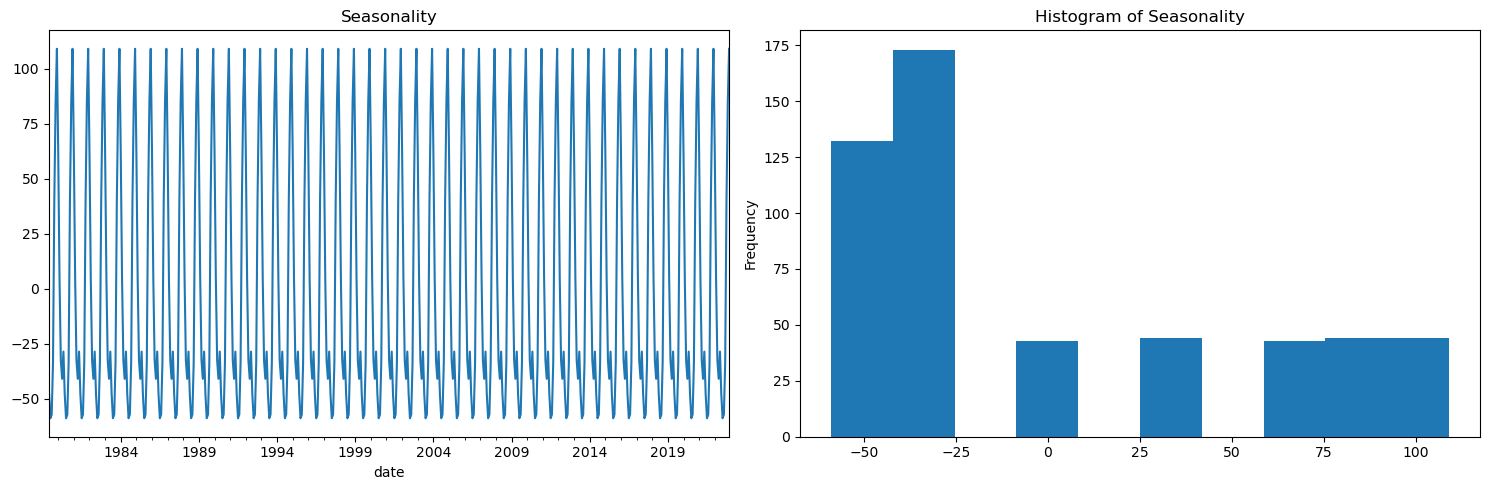

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
timeseries_decompose.seasonal.plot(ax=axs[0])
axs[0].set_title('Seasonality')
timeseries_decompose.seasonal.plot.hist(ax=axs[1])
axs[1].set_title('Histogram of Seasonality')
plt.tight_layout()

## Descriptive Statistics and Tests

### Tests for Stationarity

A time series is **`stationary`** if the `mean` and `variance` are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same.

A times series that shows `seasonality` is `not stationary`.

A test for stationarity usually involves a `unit root hypothesis test`, where the `null hypothesis` $H_0$ is that the series is **`nonstationary`**, and contains a `unit root`. 

The alternate hypothesis $H_1$ supports stationarity. 

### The **Augmented Dickey-Fuller** (**`ADF`**) and **Kwiatkowski-Phillips-Schmidt-Shin** (**`KPSS`**) tests are both stationarity tests. 

reference [Stationarity and detrending (ADF/KPSS) - statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- **Case 1**: Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2**: Both tests conclude that the series is stationary - The series is stationary
- **Case 3**: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4**: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. 

Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.

**Detrending by Differencing**

It is one of the simplest methods for detrending a time series. A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

Differencing is applied on the data and the result is plotted.

Two tests for checking the stationarity of a time series are used, namely `ADF` test and `KPSS` test. Detrending is carried out by using differencing. Trend stationary time series is converted into strict stationary time series. Requisite forecasting model can now be applied on a stationary time series data.


### [Augmented Dickey-Fuller Test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) (**`ADF`**)

In [66]:
adf_test(sealevel_timeseries_df_final['height'], alpha=0.05, title='Mean Sea Level measured by Tide Gauge')

Augmented Dickey-Fuller Test: Mean Sea Level measured by Tide Gauge
ADF Test Statistic       -2.781053
p-value                   0.061032
# Lags used              15.000000
# Observations          507.000000
Critical Value (1%)      -3.443314
Critical Value (5%)      -2.867258
Critical Value (10%)     -2.569815
At a significance level of 0.05, has weak evidence against the null hypothesis, we cannot reject the null hypothesis
Conclude that the time series data has a unit root and is non-stationary


The `Augmented Dickey-Fuller test` is used to test for the presence of a unit root in a time series sample. The test statistic is `-1.076653582570447`, which is `larger than` the `critical values at the 1%, 5%, and 10% levels (-3.470616369591229, -2.8792214018977655, and -2.57619681359045, respectively)`. 

We have a `very high p-value at 0.724292`, which `provides weak evidence` against the `null hypothesis`, and so we **`fail to reject`** the `null hypothesis`, and conclude that our dataset is **`not stationary`** and there may have **`unit root present`** in the Sea Level Data time series at any of these significance levels.

This can have implications for statistical analysis and modeling, as many `statistical methods` assume that the data being analyzed is `stationary`.

In [67]:
timeseries_decompose.resid.value_counts()

 31.554712    2
 31.893309    2
 21.714539    2
-15.841432    1
 34.590565    1
             ..
-19.368795    1
-5.401136     1
 2.283568     1
 10.313811    1
-21.345218    1
Name: resid, Length: 508, dtype: int64

In [68]:
timeseries_decompose.resid

date
1979-06-01   NaN
1979-07-01   NaN
1979-08-01   NaN
1979-09-01   NaN
1979-10-01   NaN
              ..
2022-08-01   NaN
2022-09-01   NaN
2022-10-01   NaN
2022-11-01   NaN
2022-12-01   NaN
Name: resid, Length: 523, dtype: float64

In [69]:
# Use ADF test on Sea Level Residual
adf_test(timeseries_decompose.resid, alpha=0.05, title='Mean Sea Level measured by Tide Gauge')

Augmented Dickey-Fuller Test: Mean Sea Level measured by Tide Gauge
ADF Test Statistic     -1.000136e+01
p-value                 1.880523e-17
# Lags used             1.600000e+01
# Observations          4.940000e+02
Critical Value (1%)    -3.443657e+00
Critical Value (5%)    -2.867408e+00
Critical Value (10%)   -2.569896e+00
At a significance level of 0.05, has strong evidence against the null hypothesis, we reject the null hypothesis
Conclude that the time series data has no unit root and is stationary


<Axes: ylabel='Frequency'>

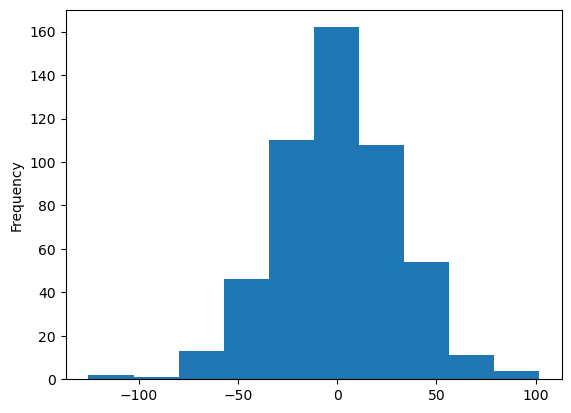

In [70]:
timeseries_decompose.resid.plot.hist()

### [Kwiatkowski-Phillips-Schmidt-Shin](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) (**`KPSS`**) test

In [71]:
kpss_test(sealevel_timeseries_df_final['height'], alpha=0.05, title='Sea Level measured by Tide Gauge')

KPSS Test: Sea Level measured by Tide Gauge
Test Statistic            2.966889
p-value                   0.010000
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
At a significance level of 0.05, we can reject the null hypothesis and conclude that the sea level time series data is not stationary.


### [Philips-Perron Test](https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.PhillipsPerron.html#arch.unitroot.PhillipsPerron) (**`PP`**) Test

In [72]:
pp_test(sealevel_timeseries_df_final['height'], alpha=0.05, title='Sea Level measured by Tide Gauge')

Phillips-Perron Test: Sea Level measured by Tide Gauge

      Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.525
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

At a significance level of 0.05, we have strong evidence against the null hypothesis, we reject the null hypothesis, and conclude that the time series data has no unit root and is stationary


### Check for assumptions for **`ADF`** test on Residuals (Error) with normality test

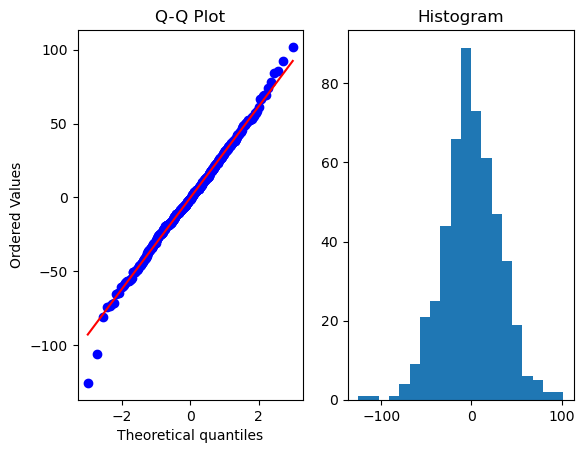

Statistic: 0.9959, p-value: 0.1984
At a significance level of 0.05, we cannot reject the null hypothesis that the time series data is normally distributed.


In [73]:
# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(sealevel_timeseries_df_final['height'], model='additive', period=12)
# Extract the residual component
residual = result.resid.dropna()

# Perform the Shapiro-Wilk test on the residual component
shapiro_wilk_test(residual)

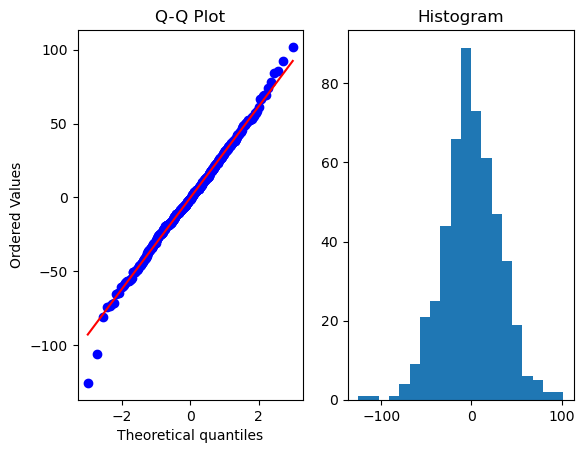

Anderson-Darling statistic: 0.3864
At a significance level of 0.15, we cannot reject the null hypothesis that the time series data is normally distributed.
At a significance level of 0.10, we cannot reject the null hypothesis that the time series data is normally distributed.
At a significance level of 0.05, we cannot reject the null hypothesis that the time series data is normally distributed.
At a significance level of 0.03, we cannot reject the null hypothesis that the time series data is normally distributed.
At a significance level of 0.01, we cannot reject the null hypothesis that the time series data is normally distributed.


In [74]:
# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(sealevel_timeseries_df_final['height'], model='additive', period=12)
# Extract the residual component
residual = result.resid.dropna()

# Anderson-Darling test 
anderson_darling_test(residual)

## Tests for Trend

### Mann-Kendall Test (**`MK`**)
The Mann-Kendall trend test is a non-parametric test that can be used to determine if there is a monotonic upward or downward trend in a time series dataset. 

The **`null hypothesis`** for the `Mann-Kendall trend test` is that there is **`no monotonic trend`** in the data. In other words, the null hypothesis assumes that the data is `independent and randomly ordered.`

The **`alternative hypothesis`** is that there is a monotonic trend in the data, either upward or downward. The Mann-Kendall test is a `non-parametric test`, which means that it does not assume any particular distribution for the data. Instead, it compares the relative magnitudes of the data points to determine if there is a trend.

To perform the Mann-Kendall trend test on the `sealevel_timeseries_df['height']` dataset using the `pymannkendall` library:

In [75]:
mk_test(sealevel_timeseries_df_final['height'], alpha=0.05, title='Sea Level measured by Tide Gauge')

Mann-Kendall Test: Sea Level measured by Tide Gauge
Trend		:increasing
H		:True
P-value		:0.0
Z		:11.2242
Tau		:0.3283
Var_s		:15938991.3333
Slope		:0.2478
Intercept	:23.3162

Conclusion:
At a significance level of 0.05, we can reject the null hypothesis and conclude that there is a significant upward trend in the time series data.


The `original_test` function from the `pymannkendall` library performs the `Mann-Kendall trend test` on the given data and returns a named tuple containing the test statistic, p-value, slope, and other information. 

The `p-value` to determine if the trend is statistically significant. 

If the p-value is less than chosen significance level (e.g., 0.05), we can reject the null hypothesis that there is no trend in the data.

The slope attribute of the result indicates the direction and magnitude of the trend. If the slope is positive, it suggests that there is an upward trend in the data, while if it is negative, it suggests that there is a downward trend.


## Exposing Seasonality with **`Month and Quarter Plots`** prior to building ARIMA model

Pandas's [Offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

1. **Identify Seasonality**: These plots can help visually identify any seasonal patterns in the data. For example, a month_plot will show the data aggregated by month, allowing us to see if there are consistent patterns that correspond to specific months. Similarly, a quarter_plot will show the data aggregated by quarter
2. **Outlier Detection**: These plots can also be useful for identifying outliers or anomalies that occur in specific months or quarters

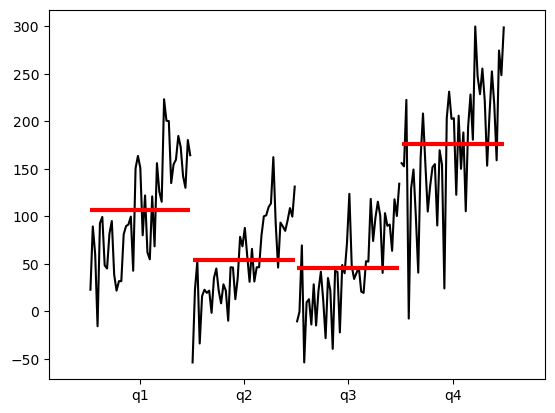

In [76]:
# rule=Q: quarter end frequency
quarter_plot(sealevel_timeseries_df_final['height'].resample(rule='Q').mean());

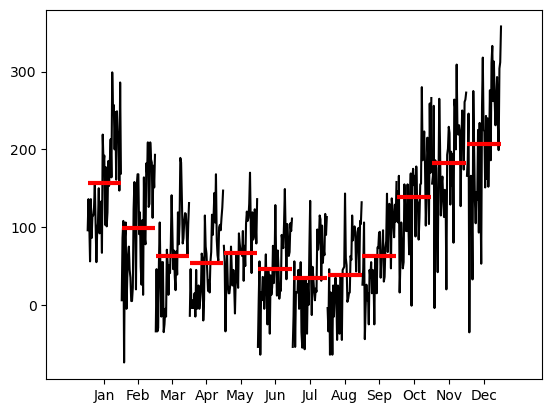

In [77]:
#rule=M: month end frequency
month_plot(sealevel_timeseries_df_final['height'].resample(rule='M').mean());

## Differencing 
To remove the trend component of time series data
### First Order Differencing 
Non-stationary data can be made to look stationary through `differencing`. A simple method called `first order differencing` calculates the difference between consecutive observations.

$$y^{\prime}_t = y_t - y_{t-1}$$

<Axes: xlabel='date'>

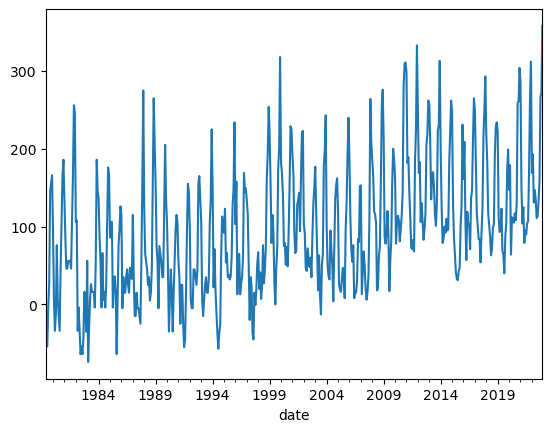

In [78]:
sealevel_timeseries_df_final['height'].plot()

In [79]:
# Apply "1st Order Differencing" to make the time series data look stationary
sealevel_timeseries_df_final['height'] - sealevel_timeseries_df_final['height'].shift(1)

date
1979-06-01      NaN
1979-07-01      0.0
1979-08-01     50.0
1979-09-01     30.0
1979-10-01    120.0
              ...  
2022-08-01     19.0
2022-09-01     26.0
2022-10-01    108.0
2022-11-01      7.0
2022-12-01     85.0
Name: height, Length: 523, dtype: float64

In [80]:
# Or by using library statsmodels.tsa.statespace.tools import diff
diff(sealevel_timeseries_df_final['height'], k_diff = 1) # noticed the first line with NaN is omitted by the function diff()

date
1979-07-01      0.0
1979-08-01     50.0
1979-09-01     30.0
1979-10-01    120.0
1979-11-01     10.0
              ...  
2022-08-01     19.0
2022-09-01     26.0
2022-10-01    108.0
2022-11-01      7.0
2022-12-01     85.0
Name: height, Length: 522, dtype: float64

<Axes: xlabel='date'>

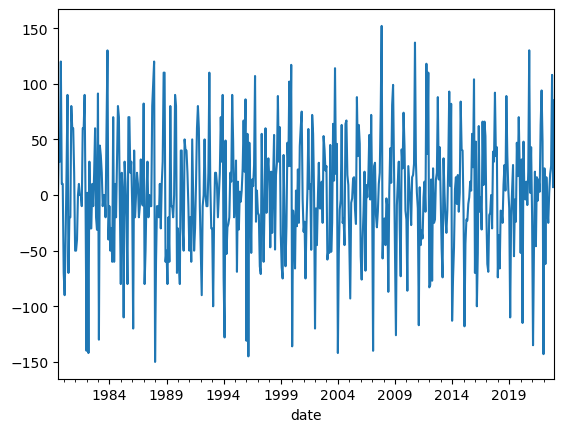

In [81]:
diff(sealevel_timeseries_df_final['height'], k_diff=1).plot()

Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in [lag_plot()](https://pandas.pydata.org/docs/reference/api/pandas.plotting.lag_plot.html) plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. 

From the plot, there is evidence of strong correlation which is indicative of autocorrelation of the non-stationary time series datasets.

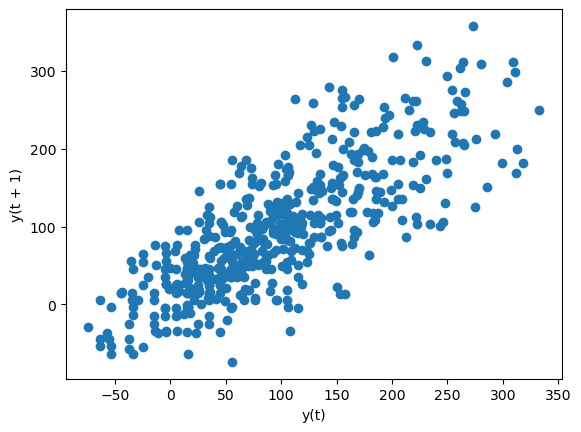

In [82]:
lag_plot(sealevel_timeseries_df_final['height']);

## `Augmented Dickey-Fuller (ADF) Test` on the `First Differencing`

It is often necessary to run the **`Augmented Dickey-Fuller (ADF)`** Test on the `first differencing of the time series data` prior to ARIMA modeling. The reason for this is that ARIMA models require the data to be **stationary**, which means that the properties of the data do not change over time without a trend.

The ADF test is a type of unit root test that checks whether a given time series is stationary or not. If the ADF test fails to reject the null hypothesis that the data are non-stationary, the recommendation of the test is to consider first-order differencing to make the data stationary.

In simpler terms, if the ADF test indicates that the time series is non-stationary, we keep differencing the time series until we have a stationary time-series. This is because non-stationary data has a time-dependent structure, which can `lead to unreliable and misleading statistics in ordinary least squares regression`.

Therefore, by ensuring stationarity through differencing and then confirming it with the ADF test, we can more reliably fit an ARIMA model to our time series data

In [83]:
# Apply "1st Order Differencing" with diff() to make the time series data look stationary
sealevel_timeseries_df_ADF_Diff = pd.DataFrame(sealevel_timeseries_df_final['height'])
sealevel_timeseries_df_ADF_Diff['d1'] = diff(sealevel_timeseries_df_ADF_Diff['height'], k_diff=1)

In [84]:
# ADF test to test for time series data stationary 
adf_test(
            sealevel_timeseries_df_ADF_Diff['d1'], 
            alpha=0.05, 
            title='Mean Sea Level measured by Tide Gauge'
            )

Augmented Dickey-Fuller Test: Mean Sea Level measured by Tide Gauge
ADF Test Statistic     -6.935473e+00
p-value                 1.057399e-09
# Lags used             1.900000e+01
# Observations          5.020000e+02
Critical Value (1%)    -3.443444e+00
Critical Value (5%)    -2.867315e+00
Critical Value (10%)   -2.569846e+00
At a significance level of 0.05, has strong evidence against the null hypothesis, we reject the null hypothesis
Conclude that the time series data has no unit root and is stationary


After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to `correct any autocorrelation` that remains in the `differenced series`.

## Forecasting procedure
1. Choose a Model
2. Split data into train and test sets
3. Fit model on training set
4. Evaluate model on test set
5. Re-fit model on entire data set
6. Forecast for future data

### ARIMA forecasting model

Parts of ARIMA(p,d,q) model, where (p,d,q) are non-negative integers

1. **AR(p): Autoregression** (number of lag observations included in the model)
    - A regression model that utilizes the `dependent relationship` between a `current observation` and `observations over a previous period (p)`.

2. **I(d): Integrated** (number of times/degree order of differencing on the raw observations)
    - `Differencing (d) of observations` (substracting an observation from an observation at the previous time step) in x-th order to make the time series `stationary`
    - Indicates that the data values have been replaced with the difference between their values and the previous values, ie. how many times needed to difference the data to get it stationary, so that the AR and MA components could work together.

3. **MA(q): Moving Average** (The size/order of moving average window)
    - A model that uses the dependency between an `observation` and a `residual error` from a `moving average model` applied to `lagged observations`. ie. plotting out `moving average` of the time series data observations, and using the `residuals error` from that `moving average model` to actual observation. 
    - Indicates the `regression error` is actually a `linear combination` of `residual error` terms whose values `occured contemporaneously` and at `various times in the past`. 


### Stationary vs Non-Stationary Data
- To use ARIMA mode, need to understand Stationarity (status) in time series data
- A time series data set made Stationary has `constant mean` (no trend) and `variance` (no seasonality) over time, ie. both mean and variance shouldn't change over time (be a function of time)
- Hence, this allow ARIMA model to predict that the mean and variance will be the same in future periods
- A common test for stationarity in time series data is by using `Augmented Dickey-Fuller (ADF) Test`.
- If the time series data is not stationary (either visually from `ACF & PACF plots`, or mathematically from `ADF test`), will then need to transform it to be stationary in order to evaluate it and determine what type of ARIMA terms (ie. `I(d)` term `Integrated Differencing (d) of observations`) will be used. 
- For `seasonal data`, could also `Differencing by a season`, ie. time series data collected monthly with `yearly seasonality (a complete cycle)`, could be differenced by a `time unit of 12`, instead of just 1
- Another common technique with seasonal ARIMA models is to combine both methods, taking the seasonal difference of the first difference.

## `Two main ways` to choose these `(p,d,q)` terms:
### 1. **`Classical Method`**: 

- Using `ACF & PACF plots`: viewing the decay (ie. sharp cut-off) in the plot
- However, these plots can be very difficult to read, even when reading correctly, `the best performing (p,d,q) value` may be `different than what is read from the chart`

### 2. **`Grid Search Method`**: 

- Run `ARIMA based models` on `various combinations of (p,d,q)` and compare the models for on some `evaluation metric`, such as `AIC scores`.
- Easy but takes time, however, with faster and cheaper in computation power, these built-in automated tools could search for the `correct (p,d,q)` fast.


### **1. `Classical Method`**: 
**AutoCorrelation Function (ACF)** and **Partial AutoCorrelation Function (PACF)** of a time series dataset prior to building ARIMA model

1. **Determine Seasonal Order**: If the data has a seasonal component, these plots can help to determine the appropriate **`seasonal order (P, D, Q)`** for a **`Seasonal ARIMA (SARIMA)`** model

2. **Check Stationarity**: Seasonal plots can also help check if the seasonal component of the time series is stationary. This is important because non-stationary data often needs to be transformed (e.g., differenced) before it can be used in an ARIMA model

3. **Understand Autocorrelation**: The **`ACF plot`** shows how correlated the values in a time series are with each other. This can help to understand the autocorrelation in the data, which is crucial for modeling time series data

4. **Understand Partial Autocorrelation**: The **`PACF plot`** captures the correlation between two variables after controlling for the effects of other variables. This can help to understand the underlying structure of the data


The `plot_acf()` and `plot_pacf()` functions from the `statsmodels.graphics.tsaplots` module are used to plot the `AutoCorrelation Function (ACF)` and `Partial AutoCorrelation Function (PACF)` of a time series dataset, respectively.

**AutoCorrelation Function (ACF):**

It is merely a bar chart of the `coefficients of correlation` between a `time series` and `lags of itself`.

- Shows the correlation between the time series and its lagged values. 
- The x-axis represents the lag and the y-axis represents the correlation coefficient. 
- The blue shaded area in the plot represents the confidence interval (CI), usually at a 95% level. ie. `correlation values outside of this CI region` are very highly likely to be a `strong conrrelation`
- If the ACF values fall outside this confidence interval, it suggests that the correlation is statistically significant.

In [85]:
sealevel_timeseries_df_final

height  height: 12mth Rolling Mean
date                                          
1979-06-01   -54.0                         NaN
1979-07-01   -54.0                         NaN
1979-08-01    -4.0                         NaN
1979-09-01    26.0                         NaN
1979-10-01   146.0                         NaN
...            ...                         ...
2022-08-01   132.0                  165.416667
2022-09-01   158.0                  169.666667
2022-10-01   266.0                  177.666667
2022-11-01   273.0                  178.416667
2022-12-01   358.0                  182.250000

[523 rows x 2 columns]

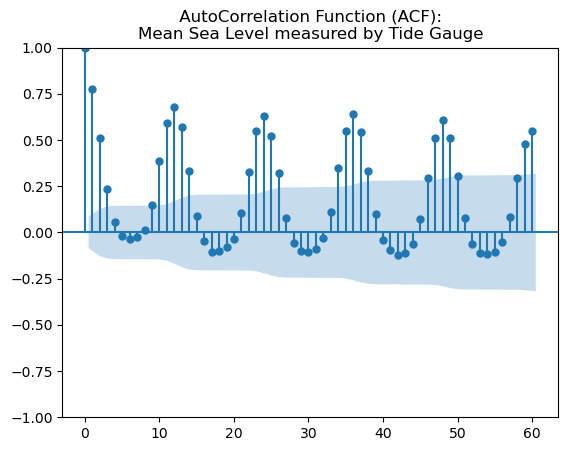

In [86]:
plot_acf(
            sealevel_timeseries_df_final['height'],
            alpha=0.05,  #95% CI 
            title =' AutoCorrelation Function (ACF): \nMean Sea Level measured by Tide Gauge',
            lags = 60
            );

Seasonality of 12 months is observed from the ACF plot above

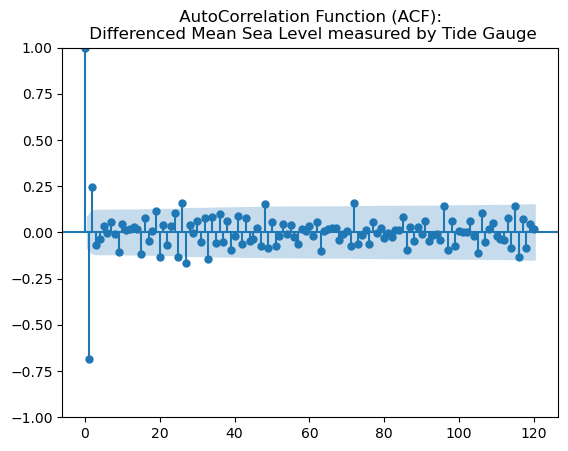

In [87]:
# If were to apply differencing with k_diff=3, 
# could see the seasonality of the time series become stationary, with very sharp drop off
plot_acf(
            diff(sealevel_timeseries_df_final['height'], k_diff = 3),
            alpha=0.05,  #95% CI 
            title =' AutoCorrelation Function (ACF): \n Differenced Mean Sea Level measured by Tide Gauge',
            lags = 120
            );

**Partial AutoCorrelation Function (PACF):** 

It is a plot of the `partial correlation coefficients` between the `time series` (current period) and `lags of itself` (previous period's residuals component of the time series).

- Shows the partial correlation between the time series and its lagged values after controlling for the effect of other lagged values. 
- Like the ACF plot, the x-axis represents the lag and the y-axis represents the partial correlation coefficient. 
- The blue shaded area in the plot represents the confidence interval, usually at a 95% level. 
- If the PACF values fall outside this confidence interval, it suggests that the partial correlation is statistically significant.

In general, we expect the PACF plot to drop off quite quickly.

Question to ask on PACF plots: 

*How many shifts does it take before it completely drops off into something that looks more like noise? Then could use this shifts number to help to choose the order parameters for ARIMA based models.*

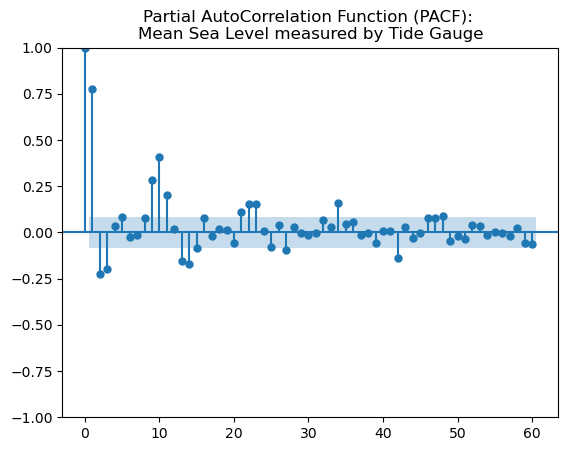

In [88]:
plot_pacf(
            sealevel_timeseries_df_final['height'],
            alpha = 0.05,   # 95% CI
            title = 'Partial AutoCorrelation Function (PACF): \nMean Sea Level measured by Tide Gauge',
            lags = 60
            );

These 2 plots (**`ACF & PACF`**) can be useful for identifying patterns in the data and for selecting appropriate orders for ARIMA model. 

1. **AR and MA signatures**: *If the `PACF` displays a `sharp cutoff` while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "**AR signature**",  meaning that the `autocorrelation pattern` can be explained more easily by adding `AR terms` than by adding MA terms.*

2. **Rule 6**: *If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The `lag` at which the `PACF cuts off` is the indicated `number of AR terms`.*

reference: [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm)

### Conclusion:

1. From the PACF plots above, and as rules of thumb, the `lag` at which the `PACF cuts off` at lag 1 is the indicated `number of AR terms`, k-order of lag 1 observed with sharp drop, suggest `AR(p=1)` shoud be used

2. And from ACF plot and also ADF test with Differencing, k_diff = 1, could test the stationarity of the time series data became stationary, suggest `I(d=1)` shoud be used

3. Since ACF plot shows `positive autocorrelation` at the `first lag (lag-1)`, this suggest to focus on the AR terms in relation to the lag, and instead of MA terms, suggest `MA(q=0)` shoud be used


However, **`grid search method`** could be better and more effective in finding out across various combinations of `ARIMA(p,d,q)` values for the ARIMA models.



[ARIMA modelling in R](https://otexts.com/fpp2/arima-r.html)

![](https://otexts.com/fpp2/arimaflowchart.png)

## **2. `Grid Search Method`**: 

Using **`Pyramid ARIMA (pmdarima)`** to conduct the Grid Search of best fitting models

It's a seperate library designed to perform grid searches across multiple combinations of `(p,d,q)` and `(P,D,Q)`

[pmdarima.arima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima)

`auto_arima()` is a stepwise approach that searches over a range of possible model orders and selects the best one based on an `information criterion such as AIC`:
- AIC helped to `penalize very high order/complexity models` if they `don't have a significant improvement` over `simpler models`, and
- AIC `avoid the model from overfitting` to the `training data`, by fitting the `best ARIMA model` with the lowest AIC value scores to the univariate time series. 

In addition, `auto_arima()` can handle `seasonal data` and can fit `seasonal ARIMA models`

In [89]:
# help(auto_arima)

## SARIMA vs ARIMA models
1. SARIMA models designed to handle seasonal data
- similar to ARIMA with parameters `(p,d,q)`, but SARIMA adds another `set of parameters (P,D,Q)` for the `seasonal components` of the model.
- `(P,D,Q)` represent the (Seasonal Regression, Differencing, Moving Average) coefficients
- `'m'` represents the number of data points (rows) in each seasonal cycle, ie. Monthly data with a Yearly Seasonal Cycle, `'m' = 12`
- statsmodels implementation of `SARIMA` is called `SARIMAX`. The `'X'` means the function also supports `exogenous regressor variables`. 

In [90]:
# Fit auto_arima function to dataset
stepwise_fit = auto_arima(
                            sealevel_timeseries_df_final['height'], 
                            start_p = 0,                # The starting value of p, the order (or number of time lags) of the auto-regressive ("AR") model. Must be a positive integer.
                            start_q = 0,                # The starting value of q, the order of the moving-average ("MA") model. Must be a positive integer.
                            max_p = 4,                  # the maximum value of P, inclusive. Must be a positive integer greater than start_P.
                            max_q = 4,                  # the maximum value of Q, inclusive. Must be a positive integer greater than start_Q
                            m = 12,                     # 12 for monthly data over a seasonal cycle
                            seasonal = True,            # Whether to fit a seasonal ARIMA
                            trace = True,               # Whether to print status on the fits. 
                            error_action = 'warn',      # 'warn': Warns when an error is encountered (default)
                            suppress_warnings = True,   # True = all of the warnings coming from ARIMA will be squelched
                            stepwise = True,            # True = significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.
                            information_criterion = 'aic'
                            )           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5636.430, Time=0.05 sec


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5506.028, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5574.890, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5634.544, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5632.405, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=5431.910, Time=0.70 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=5473.652, Time=0.55 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=5423.644, Time=1.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=5503.583, Time=0.42 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=5425.415, Time=1.20 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(3,1,1)(2,0,0)[12] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  523
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -2705.851
Date:                            Sat, 14 Oct 2023   AIC                           5421.702
Time:                                    02:01:18   BIC                           5442.990
Sample:                                06-01-1979   HQIC                          5430.040
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3637      0.041     -8.869      0.000      -0.444      -0.283
ar.L2         -0.1452      0.039     -3.745      0.000      -0.221      -0.069
ar.S.L12       0.3858      0.036     10.745      0.000       0.315       0.456
ar.S.L24       0.3943      0.035     11.267      0.000       0.326       0.463
sigma2      1825.0665     99.645     18.316      0.000    1629.767    2020.366
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.01
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let's train & test theARIMA(2,1,0)(2,0,0)[12] models, evaluate it, then produce a forecast of future values.

### Split the data into train/test sets

In [91]:
sealevel_timeseries_df_final = pd.DataFrame(sealevel_timeseries_df_final['height'])
sealevel_timeseries_df_final

height
date              
1979-06-01   -54.0
1979-07-01   -54.0
1979-08-01    -4.0
1979-09-01    26.0
1979-10-01   146.0
...            ...
2022-08-01   132.0
2022-09-01   158.0
2022-10-01   266.0
2022-11-01   273.0
2022-12-01   358.0

[523 rows x 1 columns]

In [92]:
len(sealevel_timeseries_df_final)

523

In [93]:
# Set one year for testing
train = sealevel_timeseries_df_final.iloc[ : len(sealevel_timeseries_df_final) - 12]
test = sealevel_timeseries_df_final.iloc[ len(sealevel_timeseries_df_final) - 12 : ] 

## Fit an **`SARIMA(p, d, q)(P, D, Q)[12]`** Model

In [94]:
model = SARIMAX(train['height'],
                order=(2, 1, 0), seasonal_order=(2, 0, 0, 12)
                # order=(3, 0, 0), seasonal_order=(2, 1, 0, 12)
                )

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             height   No. Observations:                  511
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -2645.400
Date:                            Sat, 14 Oct 2023   AIC                           5300.801
Time:                                    02:01:19   BIC                           5321.973
Sample:                                06-01-1979   HQIC                          5309.101
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3534      0.041     -8.534      0.000      -0.435      -0.272
ar.L2         -0.1358      0.040     -3.436      0.001      -0.213      -0.058
ar.S.L12       0.3888      0.036     10.660      0.000       0.317       0.460
ar.S.L24       0.3836      0.036     10.769      0.000       0.314       0.453
sigma2      1838.2244    102.158     17.994      0.000    1637.998    2038.451
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
start = len(train)
print(f'start:{start}')
end = len(train) + len(test) - 1
print(f'end:{end}')
print(f'len(df):{len(sealevel_timeseries_df_final)}')

start:511
end:522
len(df):523


In [96]:
# Obtain predicted values
predictions = results.predict(
                                start = len(train),
                                end = len(train) + len(test) - 1,
                                dynamic = False,                    #forecasts at each point are generated using the full history up to that point (all lagged values)
                                typ='levels'                        # for model with differencing I(d) term, to avoid fitting with this term. default 'linear'
                                ).rename('SARIMA(2,1,0)(2,0,0,12) Predictions')
                                # ).rename('SARIMA(3,0,0)(2,1,0,12) Predictions')

In [97]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:.1f}, expected={test['height'][i]}")

predicted=268.4, expected=169.0
predicted=231.1, expected=193.0
predicted=170.0, expected=131.0
predicted=195.7, expected=147.0
predicted=176.8, expected=136.0
predicted=181.5, expected=111.0
predicted=184.2, expected=113.0
predicted=186.2, expected=132.0
predicted=195.4, expected=158.0
predicted=269.7, expected=266.0
predicted=307.1, expected=273.0
predicted=342.2, expected=358.0


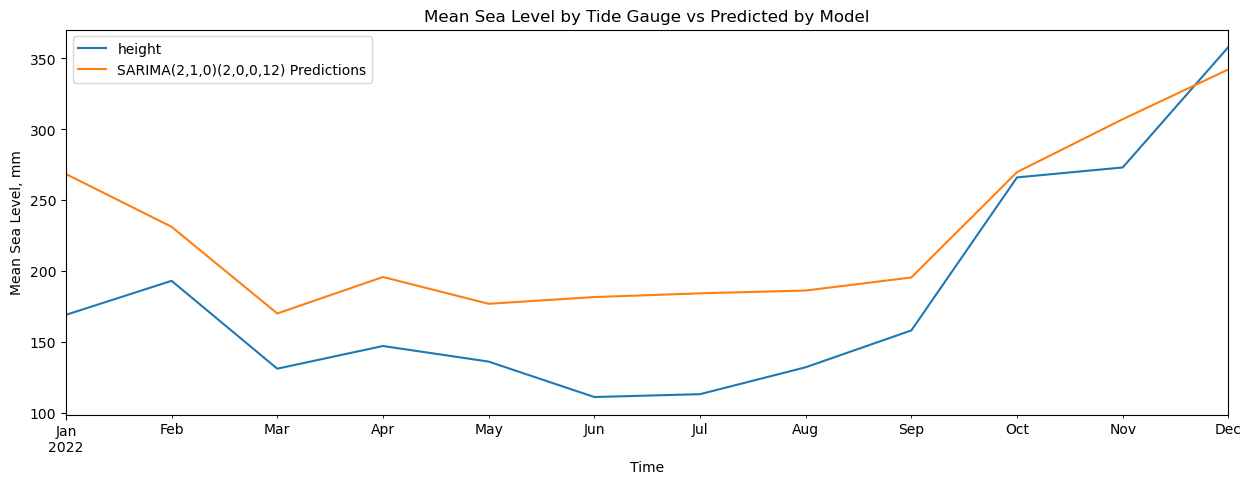

In [98]:
# Plot predictions against known values in test set
ax = test['height'].plot(legend = True, figsize = (15,5), title = 'Mean Sea Level by Tide Gauge vs Predicted by Model')
predictions.plot(legend=True)
ax.autoscale(axis = 'x',tight = True)
ax.set(xlabel = 'Time', ylabel = 'Mean Sea Level, mm')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_formatter(formatter);

## **Evaluate the Model**

Evaluation metrics like `accuracy` or `recall` aren't useful for time series forecasting because they are actually for predicting categories and evaluating error for classification problems. 

Evaluation Metrics designed for continuous values of time series are:
1. `Mean Absolute Error, MAE`: simply averaging the residuals, will miss large predicted erros with just a few points
- $MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{t+l}} - \hat y_{t+l}\mid$
2. `Mean Squared Error, MSE`: large predicted errors will be captured due to the squared term even just a few points are off, thus better than MAE, but with units also squared, ie. height^2 in mm^2 
- $MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{t+l} - \hat y_{t+l})^2$
3. `Root Mean Square Error, RMSE`: convert the MSE squared error term to original units, ie. height in mm, best to use it to compare with average values of dataset's test set. 
- $RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{t+l} - \hat y_{t+l})^2}$



In [99]:
test['height'].describe()

count     12.000000
mean     182.250000
std       77.119889
min      111.000000
25%      131.750000
50%      152.500000
75%      211.250000
max      358.000000
Name: height, dtype: float64

In [100]:
model_order = 'SARIMA(2,1,0)(2,0,0,12)'
# model_order = 'SARIMA(3,0,0)(2,1,0,12)'

mae_error = mean_absolute_error(test['height'], predictions)
mse_error = mean_squared_error(test['height'], predictions)
rmse_error = rmse(test['height'], predictions)

print(f'{model_order} MAE Error: {mae_error:.4f}')
print(f'{model_order} MSE Error: {mse_error:.4f}')
print(f'{model_order} RMSE Error: {rmse_error:.4f}')
print(f'{model_order} RMSE Error: {np.sqrt(mse_error):.4f}') # RMSE by just sqrt() of MSE


SARIMA(2,1,0)(2,0,0,12) MAE Error: 46.0641
SARIMA(2,1,0)(2,0,0,12) MSE Error: 2723.0410
SARIMA(2,1,0)(2,0,0,12) RMSE Error: 52.1828
SARIMA(2,1,0)(2,0,0,12) RMSE Error: 52.1828


### Retrain the model on the full data, and forecast the future

In [101]:
model = SARIMAX(
                sealevel_timeseries_df_final['height'],
                order=(2, 1, 0), seasonal_order=(2, 0, 0, 12)
                # order=(3, 0, 0), seasonal_order=(2, 1, 0, 12)
                        )

results = model.fit()

In [102]:
fcast = results.predict(
                        len(sealevel_timeseries_df_final),
                        len(sealevel_timeseries_df_final) + 12,
                        typ='levels'
                        ).rename('SARIMA(2,1,0)(2,0,0,12) Predictions')
                        # ).rename('SARIMA(3,0,0)(2,1,0,12) Predictions')

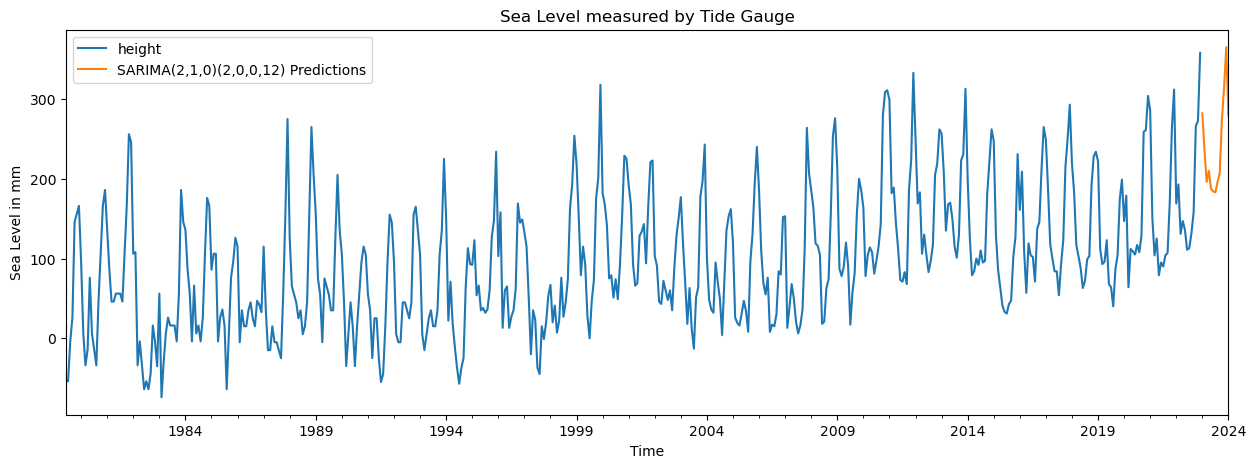

In [103]:
# Plot predictions beyond current time frame
ax = sealevel_timeseries_df_final['height'].plot(
                                                legend=True,
                                                figsize=(15,5),
                                                title='Sea Level measured by Tide Gauge')
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Time' , ylabel='Sea Level in mm')
ax.yaxis.set_major_formatter(formatter);

## Conclusion

### Findings from tide-gauge stations Mean Sea Level (MSL) Dataset 

1. **Linear regression model**: **`-1.00 mm/year ~ +6.88 mm/year`** for different location, may not be suitable for Sea Level Rise modeling, to fully capture the trend due to seasonality, and cyclical nature of Sea Level Rise data.
2. **Mann-Kendall trend test**: **`50% of MSL`** measured are with **`upward trend`**, and **`remaining shows no trend`**
3. **ADF test**: **`>70% of MSL`** are **`not stationary`**
4. **KPSS test**: **`35% of MSL`** measured are **`not stationary`**
5. **PP test**: **`7% of MSL`** measured are **`not stationary`**
6. **Tide-gauges measurement accuracy/precision** are technology dependent, with large variance in the estimating MSL.
7. **`SARIMA(p,d,q)(P,D,Q)[m]`** model with extra parameters **(P,D,Q)** for the **seasonal components** better than **ARIMA(p,d,q)**, with best **AIC Information Criterion**, **`SARIMA(2,1,0)(2,0,0,12)`** model as best-fit for the time series Mean Sea Level data with lower RMSE Error
8. **Mean Sea Level Rising** also dependent on more complex geophysical driving mechanisms of climate change (which are outside the scope of this project) including:
    - radiative forcing 
    - greenhouse gas emission and concentration futures
    - ice-sheet processes, such as MICI (Marine Ice Cliff Instability)

## Reference:

1. "**Mapping Sea-Level Change in Time, Space, and Probability**", Dr Benjamin P. Horton et al. Annu. Rev. Environ. Resour. 2018. 43:481–521, 2018 https://www.annualreviews.org/doi/pdf/10.1146/annurev-environ-102017-025826

2. "**Changes in extreme high water levels based on a quasi‐global tide‐gauge data set**", Menéndez - 2010 - Journal of Geophysical Research: Oceans - Wiley Online Library

3. "**Deglacial perspectives of future sea level for Singapore**", Shaw, T.A., Li, T., Ng, T. et al. Commun Earth Environ 4, 204 (2023). https://doi.org/10.1038/s43247-023-00868-5 

4. "**Tide Gauge Data**", Permanent Service for Mean Sea Level (PSMSL), Retrieved 31 Jul 2023 from http://www.psmsl.org/data/obtaining/

5. "**New Data Systems and Products at the Permanent Service for Mean Sea Level**". Simon J. Holgate, Andrew Matthews et. al. (2013) Journal of Coastal Research: Volume 29, Issue 3: pp. 493 – 504. doi:10.2112/JCOASTRES-D-12-00175.1.

6. "**Climate Science, Risk & Solutions (Climate Knowledge for Everyone)**", Dr. Kerry Emanuel, Atmospheric Science, MIT https://climateprimer.mit.edu/climate-science-risk-solutions.pdf

7. "**Sea level trend and variability in the Singapore Strait**", Tkalich, P., Vethamony, P., Luu, Q.-H., and Babu, M. T. , Ocean Sci., 9, 293–300, https://doi.org/10.5194/os-9-293-2013, 2013